# Jacoubet Atlas of Paris project

Nicolas PORTAL, Anh DUONG, Manuel TERTRE, Kathialina VA - EPITA IMAGE 2021

This notebook is one the three notebooks used during this projet:
* **Number localization** notebook: this notebook, it detects where are the numbers and then uses models from the two other notebook in order to classify them.
* **isDigit** notebook: trains a model which will decide if the input is a number ot not.
* **digit classification model** notebook: trains a model which will identify the image number given in input.

# Initialization
Since this project involves detecting numbers from maps of the *Jacoubet Atlas of Paris*, we first load the data given to us.

In [1]:
# dataset link: https://www.kaggle.com/paduong/jacoubet/
# model link: https://www.kaggle.com/paduong/ign-model

PATH_TO_DIRECTORY = '/kaggle/input/jacoubet'
IMG_PATHS = !ls $PATH_TO_DIRECTORY/*.jpg | sort
IMG_PATHS

['/kaggle/input/jacoubet/Atlas_de_Jacoubet_-_04._Partie_de_la_commune_de_Clichy_et_de_ses_environs_-_BHVP.jpg',
 '/kaggle/input/jacoubet/Atlas_de_Jacoubet_-_05._Partie_de_la_commune_de_Montmartre_et_de_ses_environs_-_BHVP.jpg',
 '/kaggle/input/jacoubet/Atlas_de_Jacoubet_-_06._Partie_de_la_commune_de_La_Chapelle_et_de_ses_environs_-_BHVP.jpg',
 '/kaggle/input/jacoubet/Atlas_de_Jacoubet_-_07._Barrire_de_la_Villette_et_ses_environs_-_BHVP.jpg',
 '/kaggle/input/jacoubet/Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses_environs_-_BHVP.jpg']

(8021, 6346)


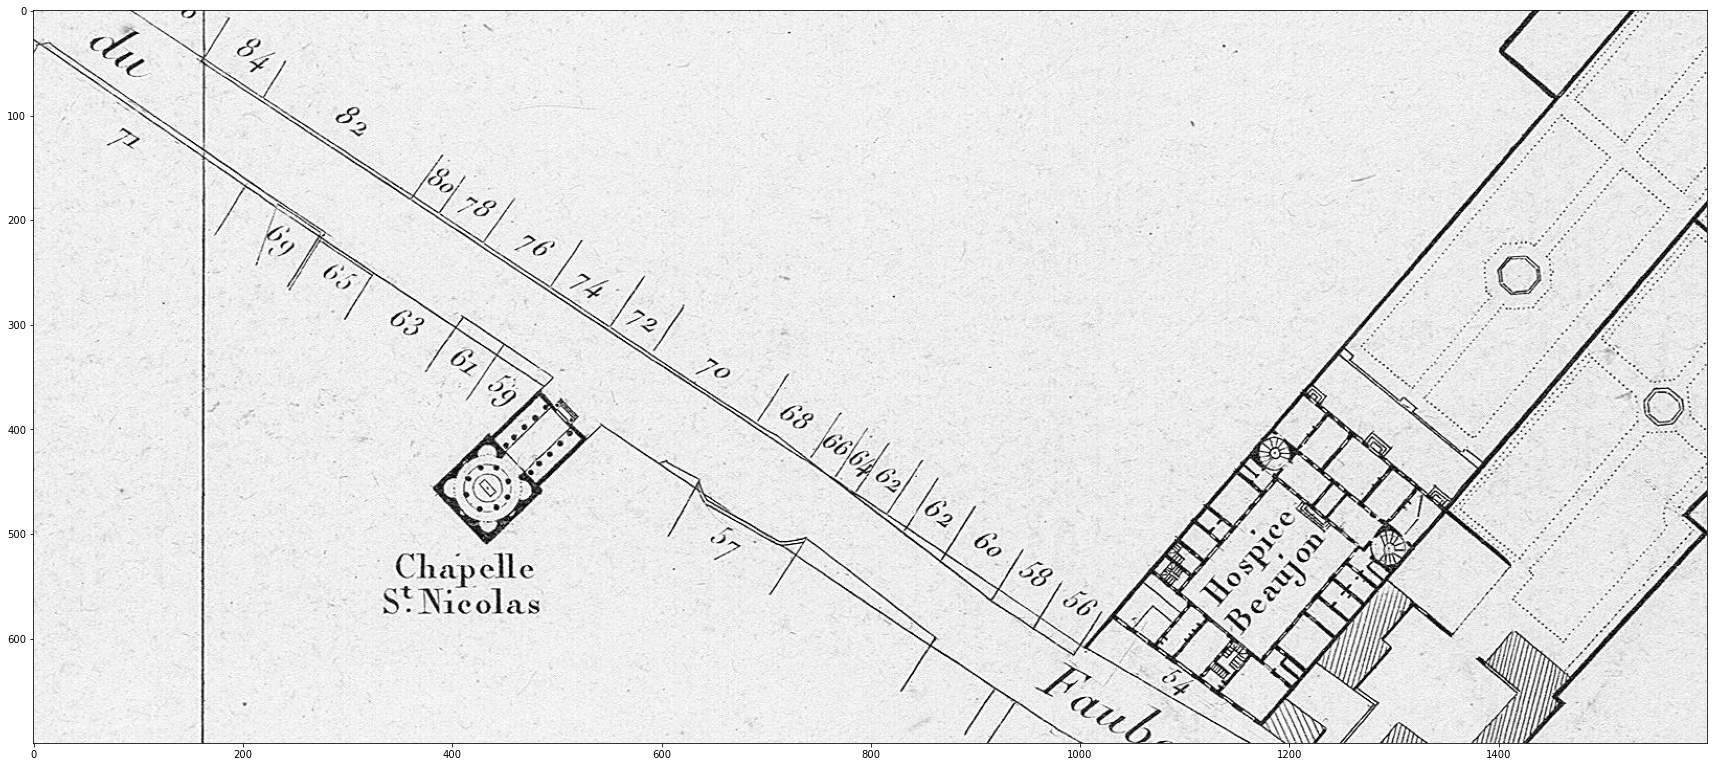

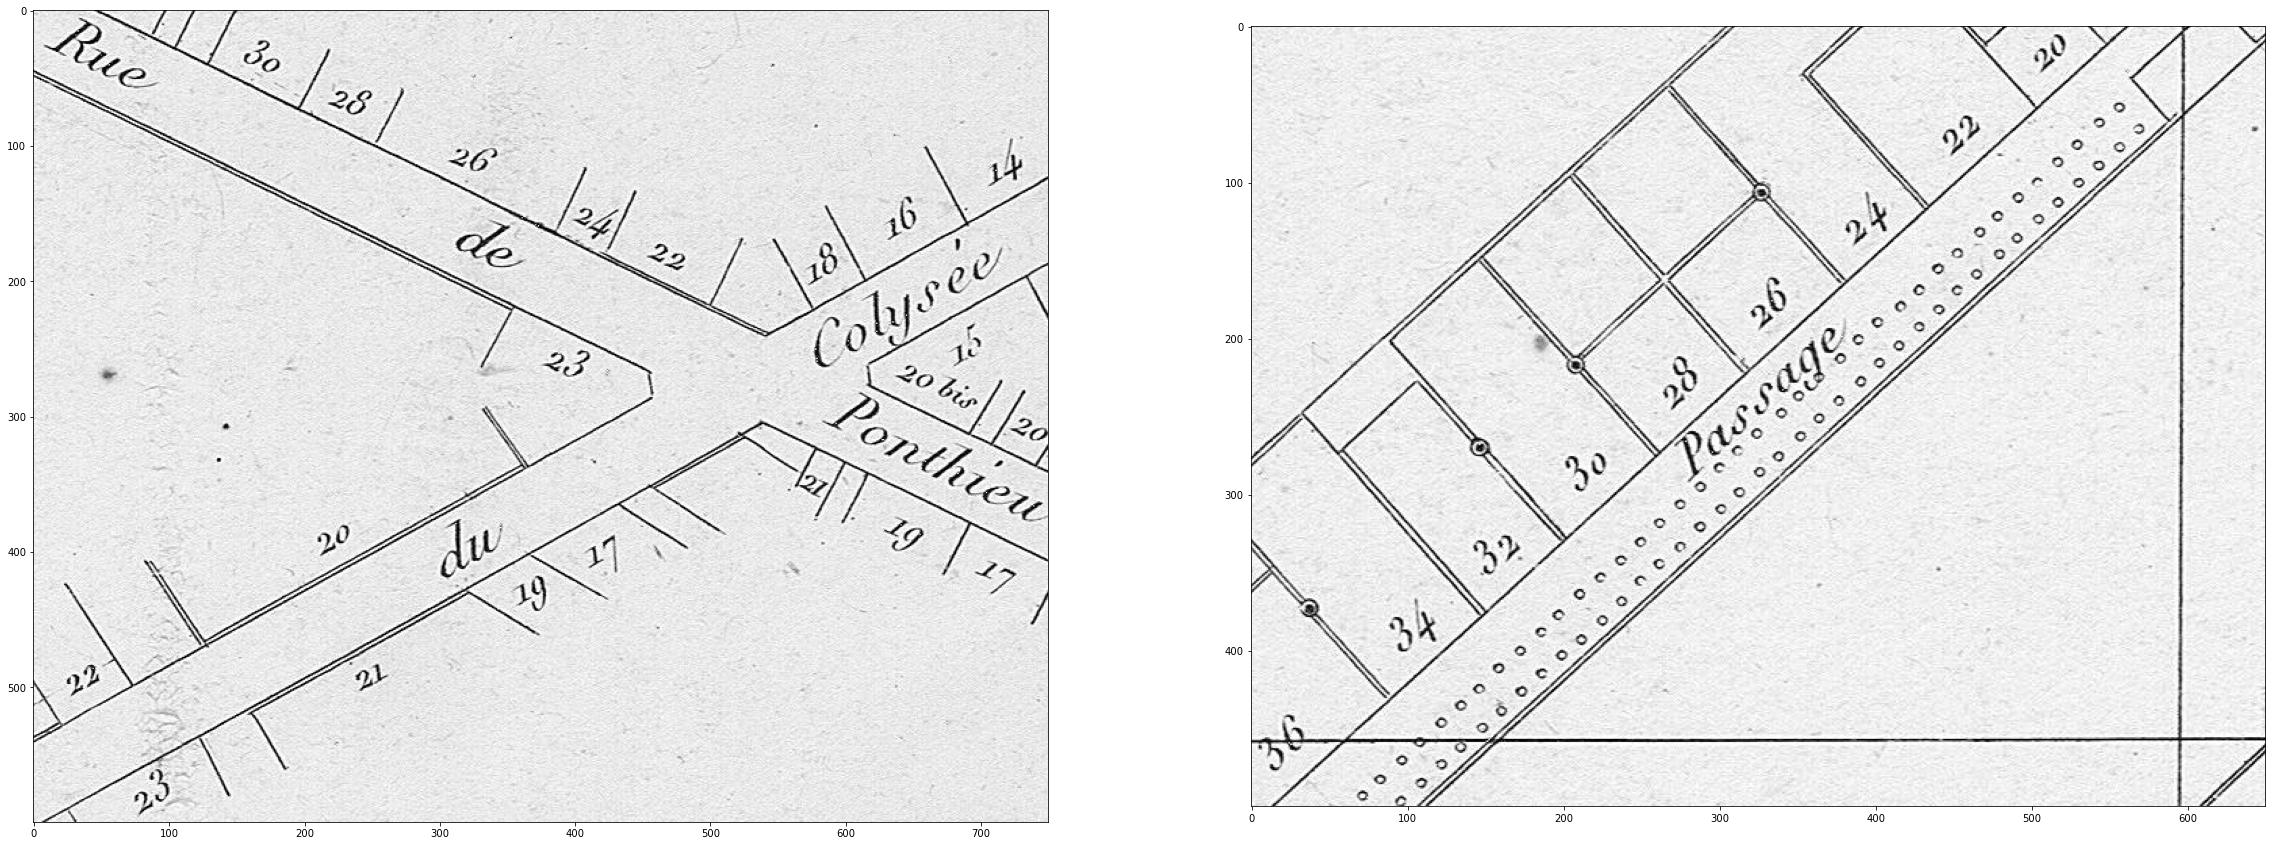

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

images = [cv2.imread(path, 0) for path in IMG_PATHS]
image = images[4] # We work with image 4 ("11.Hospice Beaujon et ses environs")

print(image.shape)

plt.figure(figsize=(30, 20))
plt.imshow(image[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(image[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(image[4300:4800, 1100:1750], cmap='gray')

# plt.imshow(image[4700:5900, 700:2500], cmap="gray")#07

# Image preprocessing
We increase contrast, remove some noise and use otsu threshold to get the binary equivalent image that we will work with from now on. 

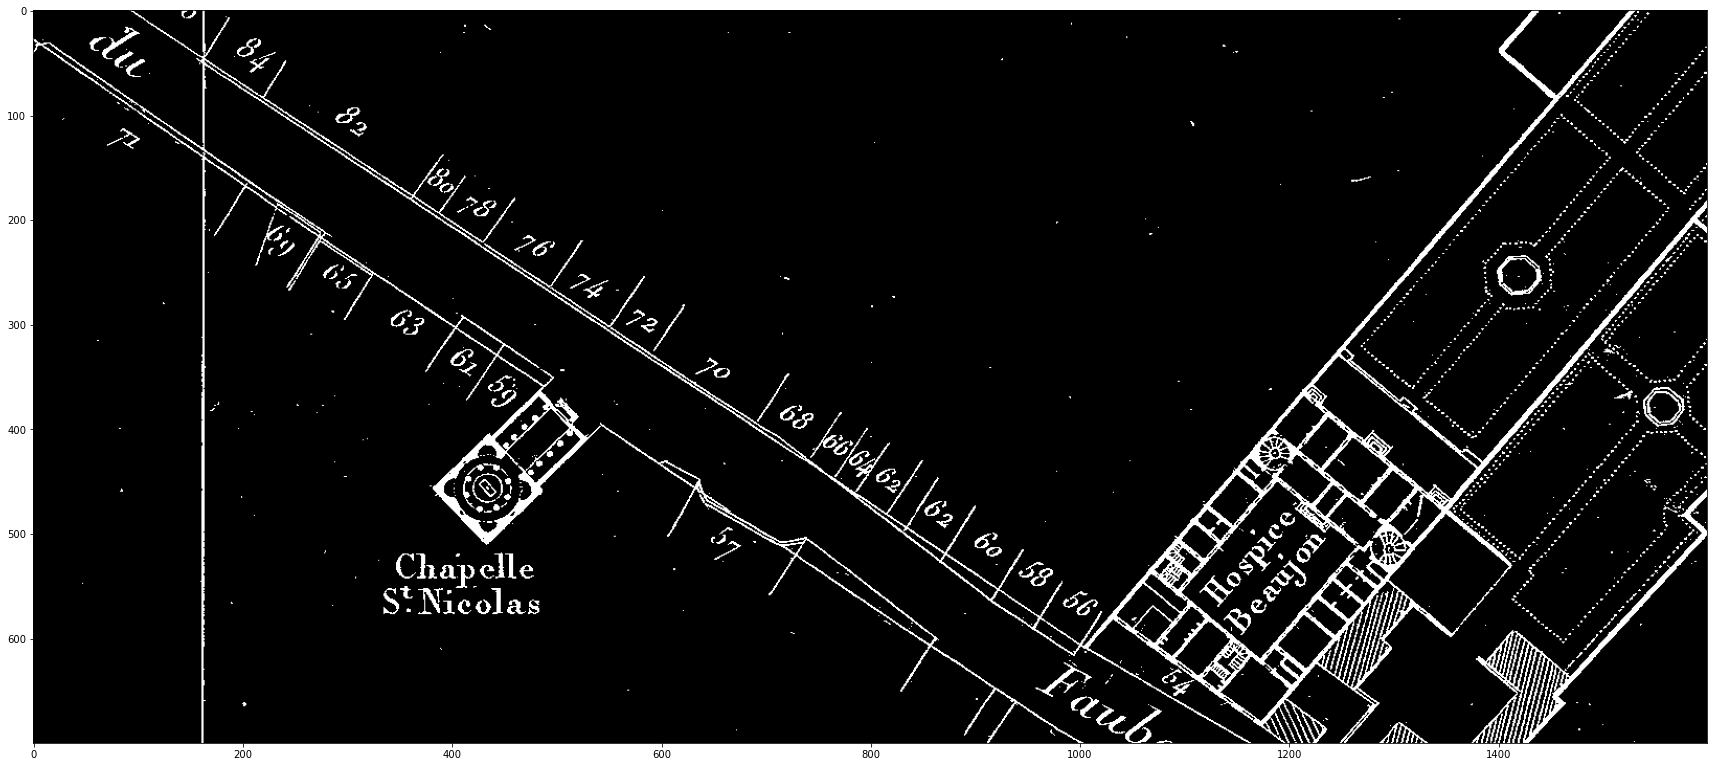

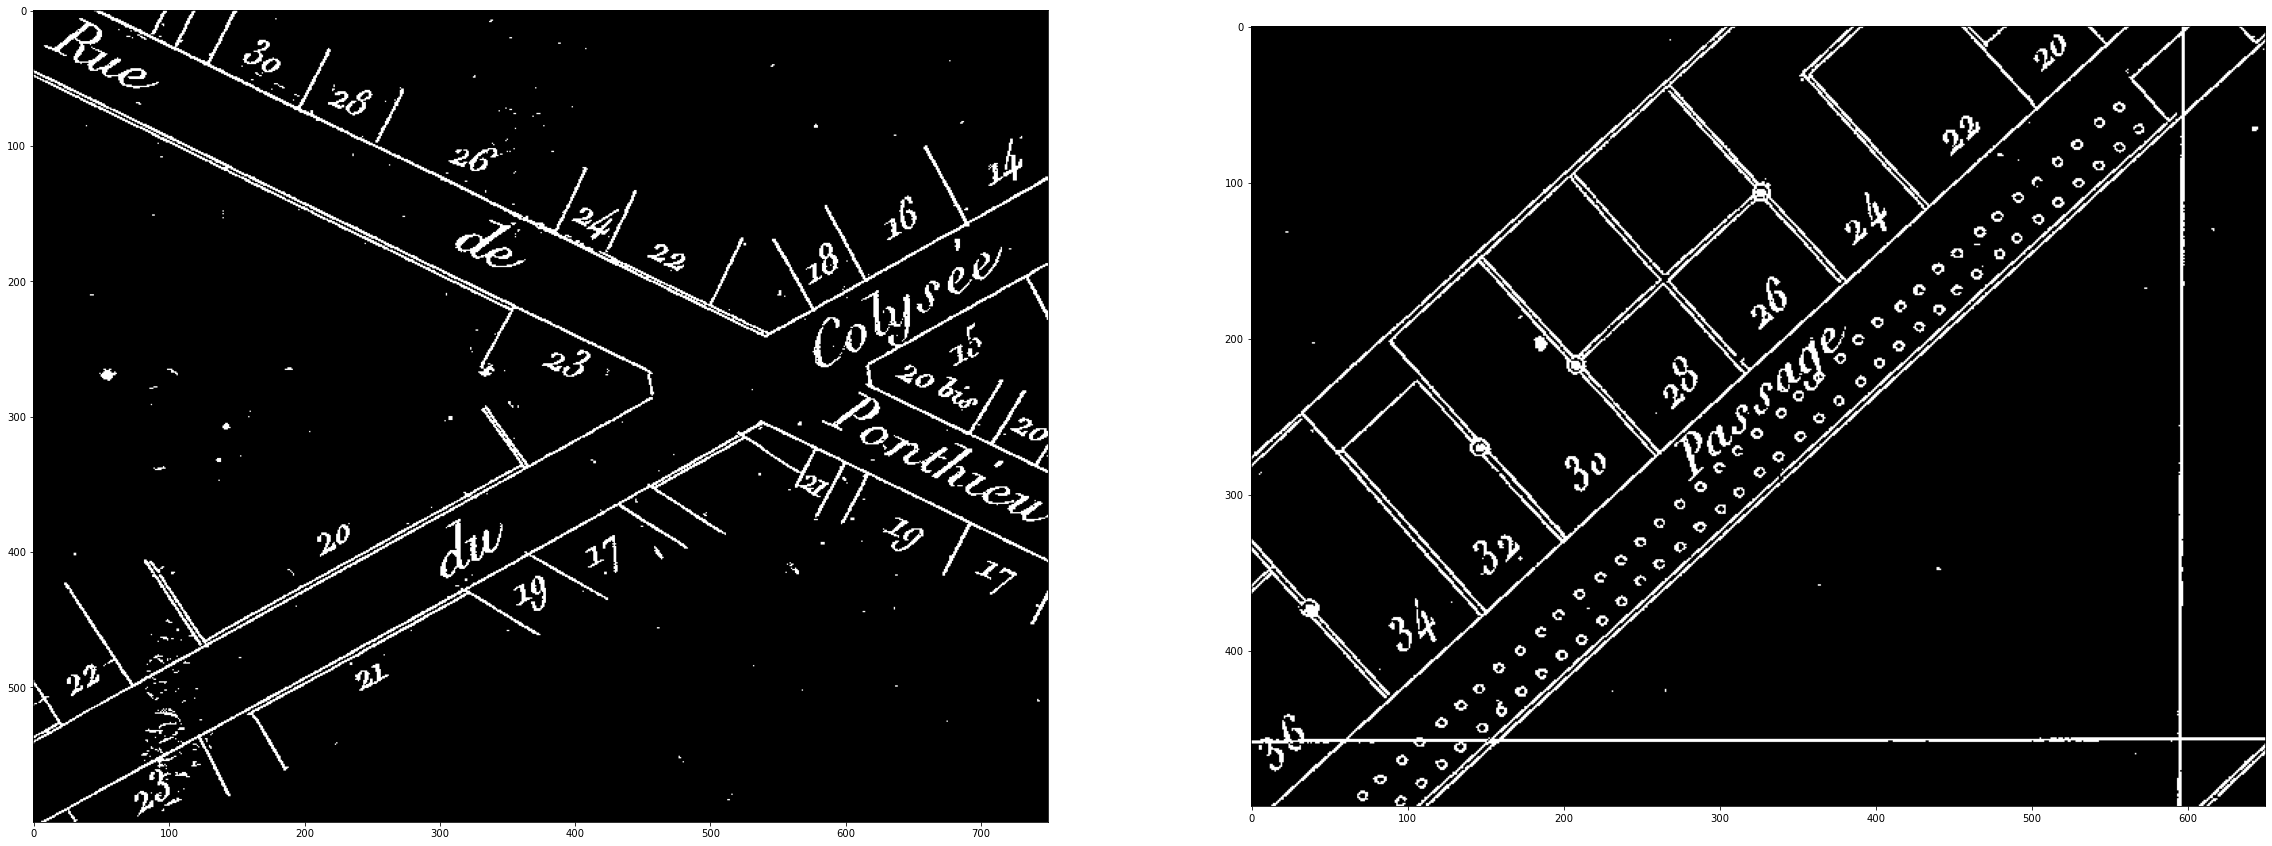

In [3]:
def getBinary(img):
    #apply adaptive histogram equalization to improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(100, 100))
    img = clahe.apply(img)
    
    #apply bilateralFilter to remove noise while keep edges sharp
    img = cv2.bilateralFilter(img, 11, 17, 17)
    
    _, img = cv2.threshold(img, 0, 255, type=cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    return img

binary_img = getBinary(image)

plt.figure(figsize=(30, 20))
plt.imshow(binary_img[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(binary_img[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(binary_img[4300:4800, 1100:1750], cmap='gray')

To best detect numbers from the map, we remove lines and unnecessary things visible in the image. We use openCV's HoughLinesP that will detect lines depending to various parameters, and then erase it by simply coloring them in black.

removeBigLines: Done
CPU times: user 21 s, sys: 190 ms, total: 21.2 s
Wall time: 21.2 s


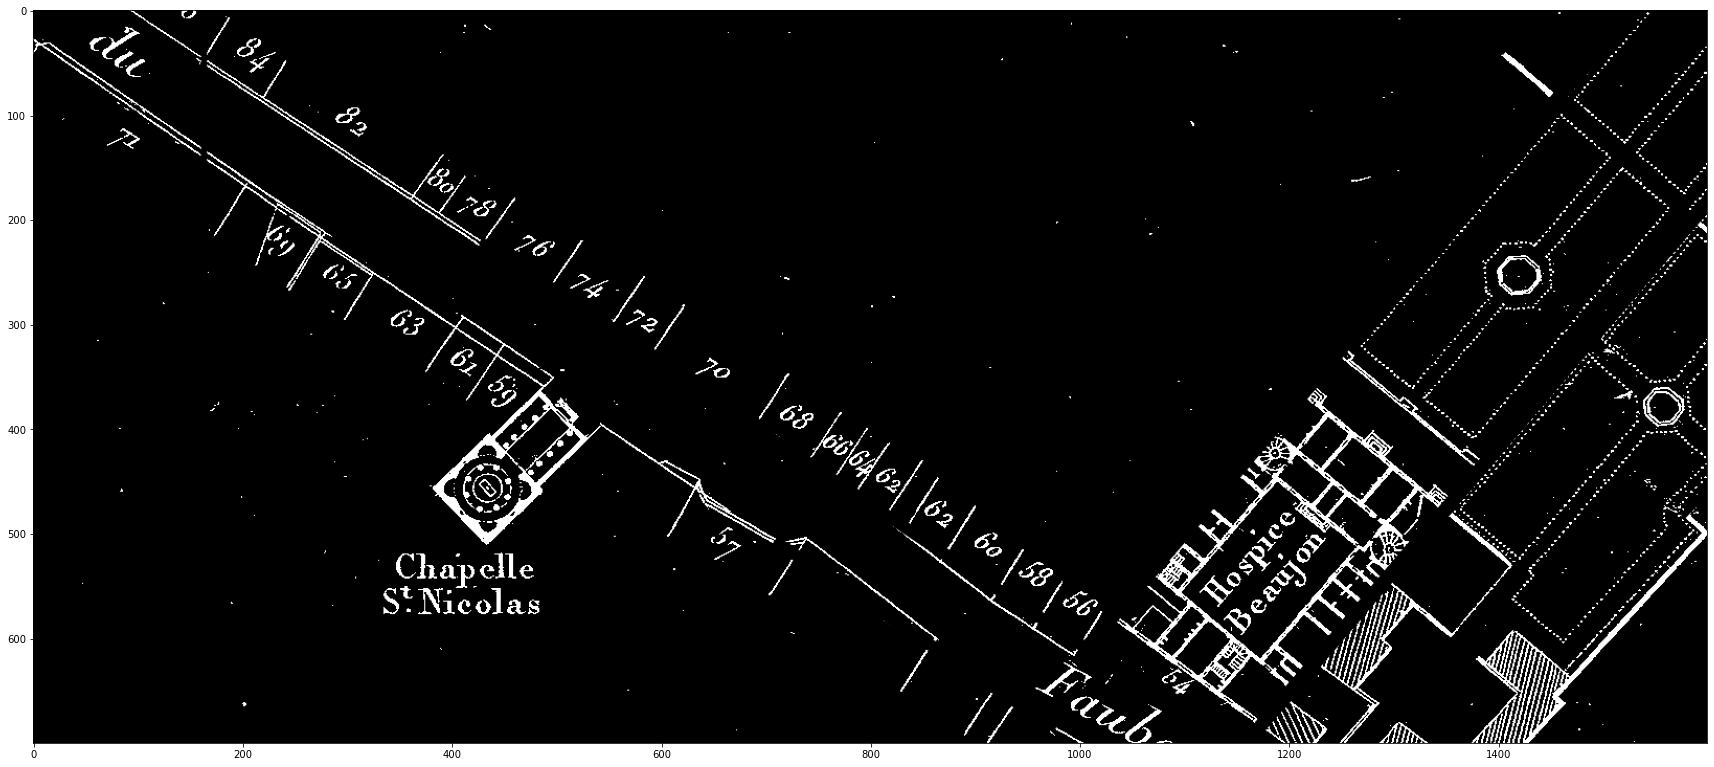

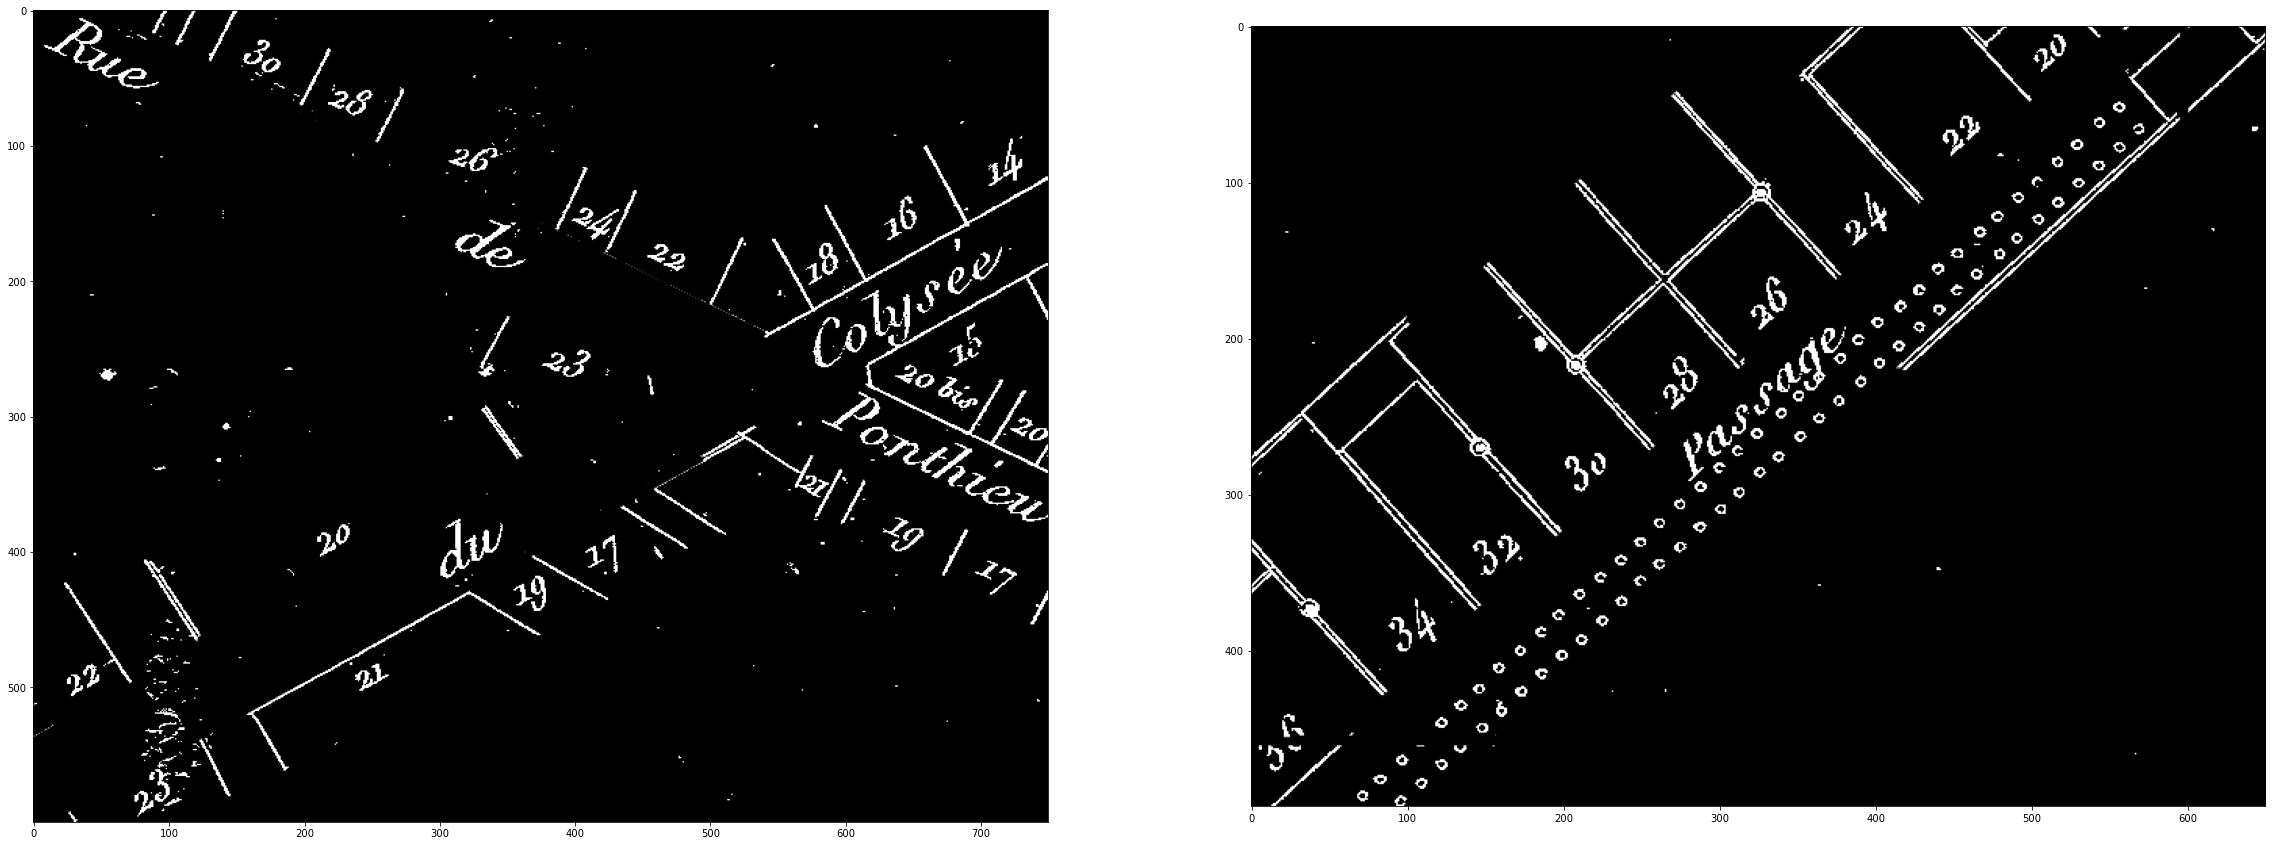

In [4]:
%%time

def removeLines(image, lines, thickness=3):
    if lines is not None:
        for line in lines:
            coords = line[0]
            cv2.line(image, (coords[0], coords[1]), (coords[2], coords[3]), (0,0,0), thickness, cv2.LINE_AA)

def removeBigLines(image):
    print( "removeBigLines: ", 0, end='\r', flush=False)

    #remove big lines that cross numbers => we wont lose numbers, crossed by those lines,when removing big objects
    #ex: number 36
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=100, minLineLength=500, maxLineGap=1)
    removeLines(image, lines, thickness=3) 

    print( "removeBigLines: ", 33, end='\r', flush=False)

    #remove other big lines
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/720, threshold=20, minLineLength=200, maxLineGap=1)
    removeLines(image, lines, thickness=9)

    print( "removeBigLines: ", 66, end='\r', flush=False)

    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/720, threshold=20, minLineLength=200, maxLineGap=1)
    removeLines(image, lines, thickness=9)
    
    print("removeBigLines: Done")
    

removeBigLines(binary_img)


plt.figure(figsize=(30, 20))
plt.imshow(binary_img[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(binary_img[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(binary_img[4300:4800, 1100:1750], cmap='gray')

We also use skimage labelling of connected objets to remove objects that are too large to be a number.

removeLargeObjects: DONE
CPU times: user 14.2 s, sys: 887 ms, total: 15.1 s
Wall time: 15 s


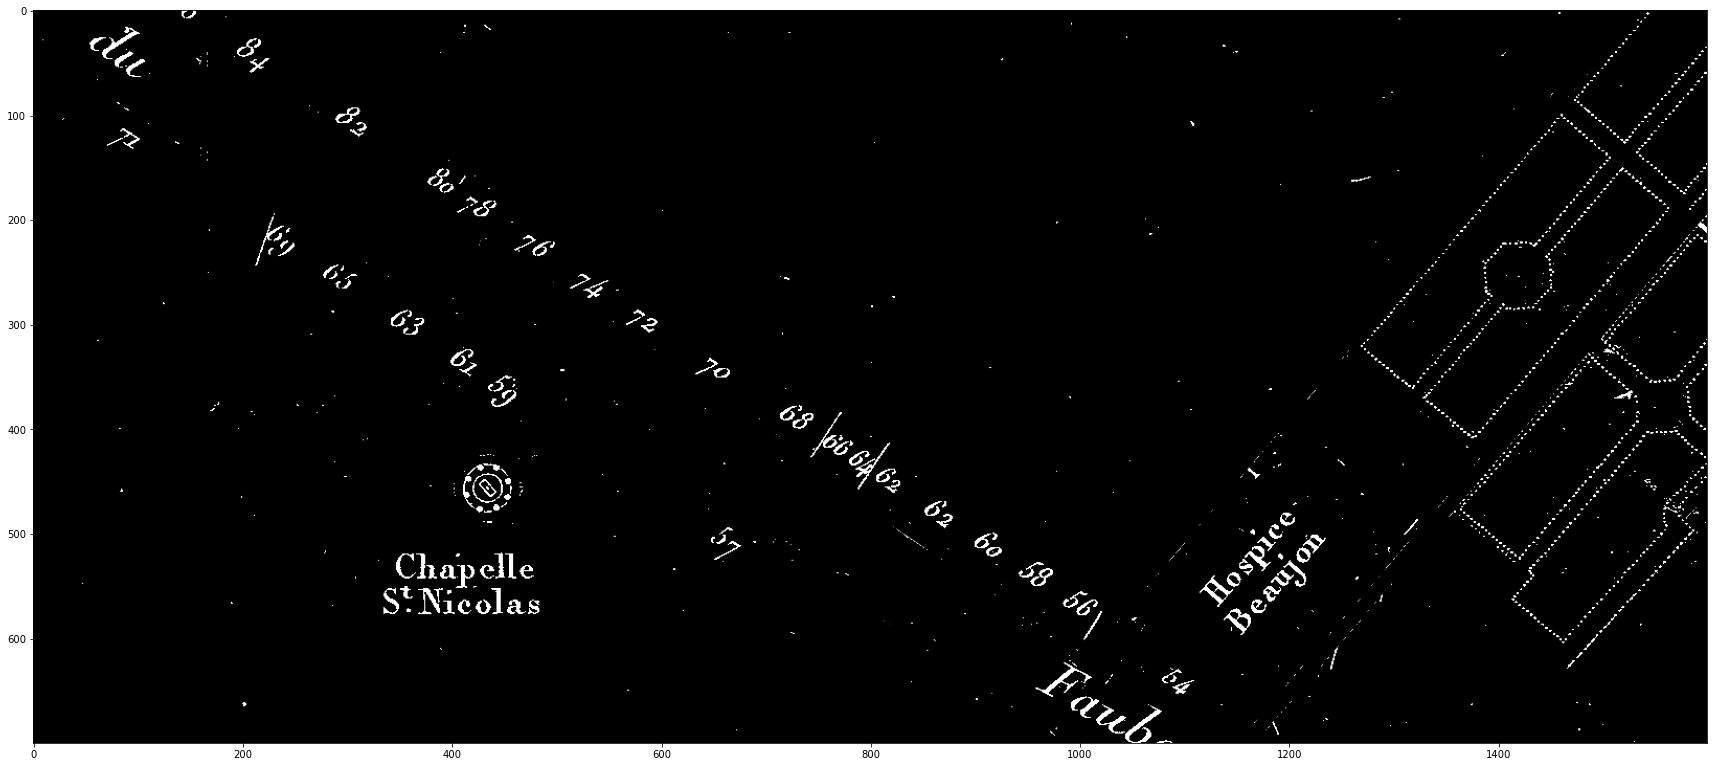

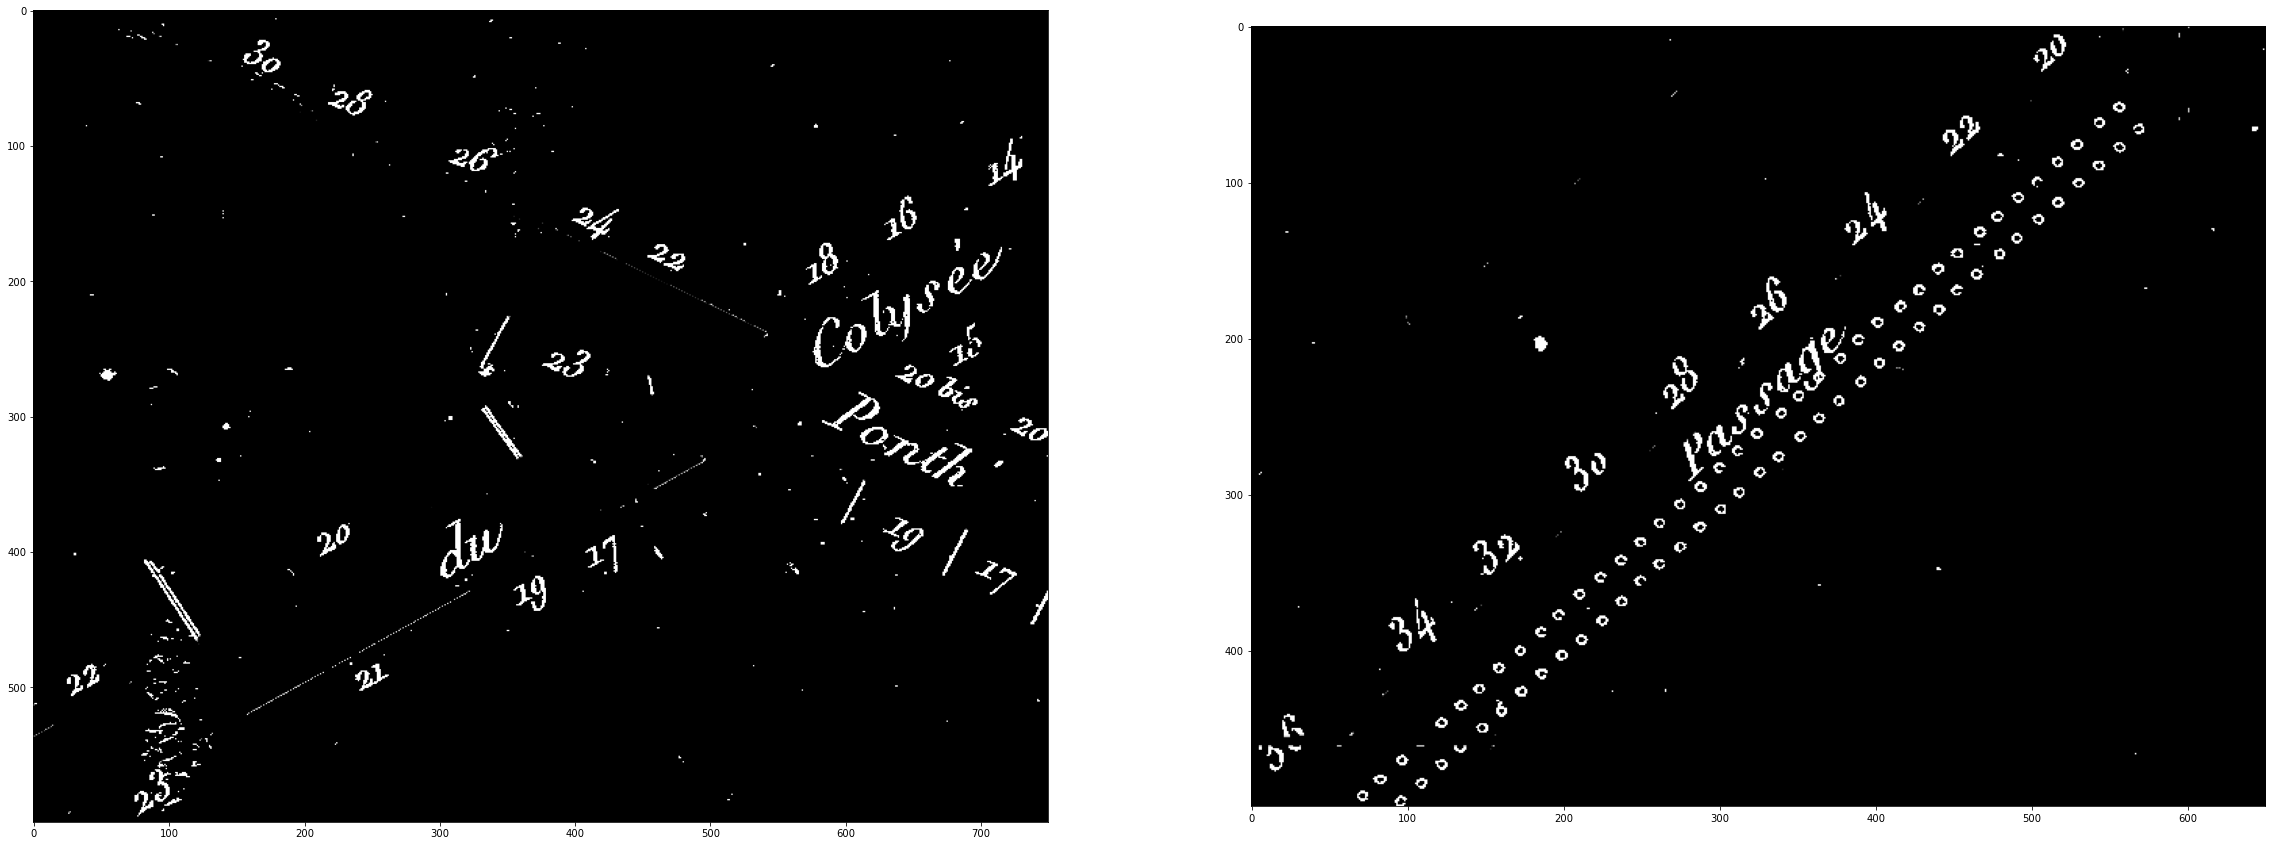

In [5]:
%%time

from skimage import measure
from skimage import filters
from skimage import morphology
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches


def removeLargeObjects(image):
    print("removeLargeObjects", end="\r", flush=False)
    label_image = measure.label(image)
    for region in regionprops(label_image):
        if region.area > 300 or region.minor_axis_length > 0 and region.major_axis_length / region.minor_axis_length > 15:
            for coordinates in region.coords:  
                image[coordinates[0], coordinates[1]] = 0
    
    print("removeLargeObjects: DONE")
   


removeLargeObjects(binary_img)

plt.figure(figsize=(30, 20))
plt.imshow(binary_img[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(binary_img[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(binary_img[4300:4800, 1100:1750], cmap='gray')

removeSmallLines: DONE
CPU times: user 5.21 s, sys: 102 ms, total: 5.31 s
Wall time: 5.3 s


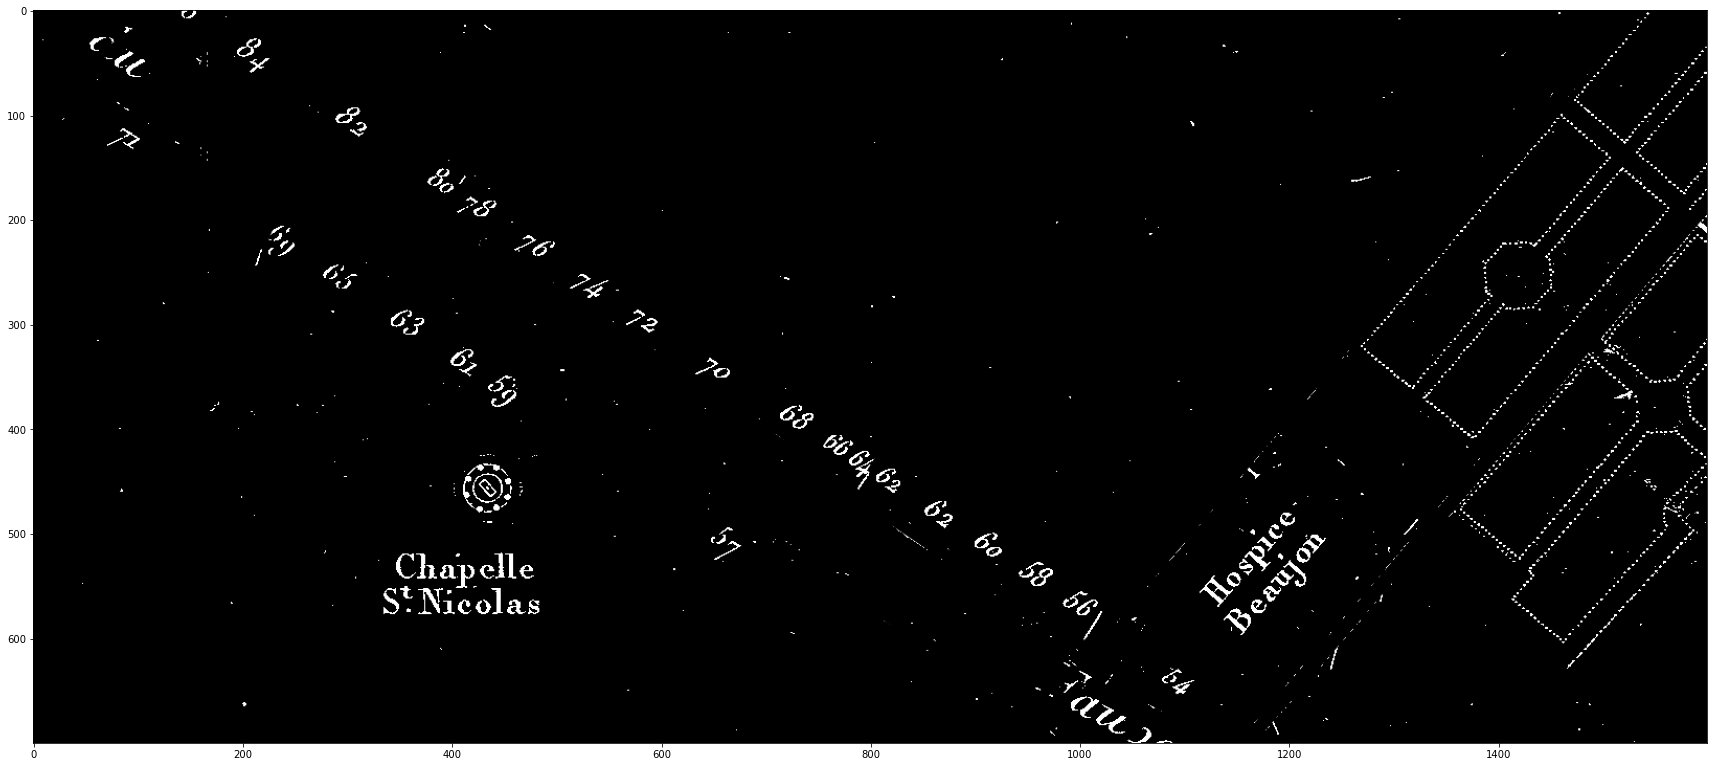

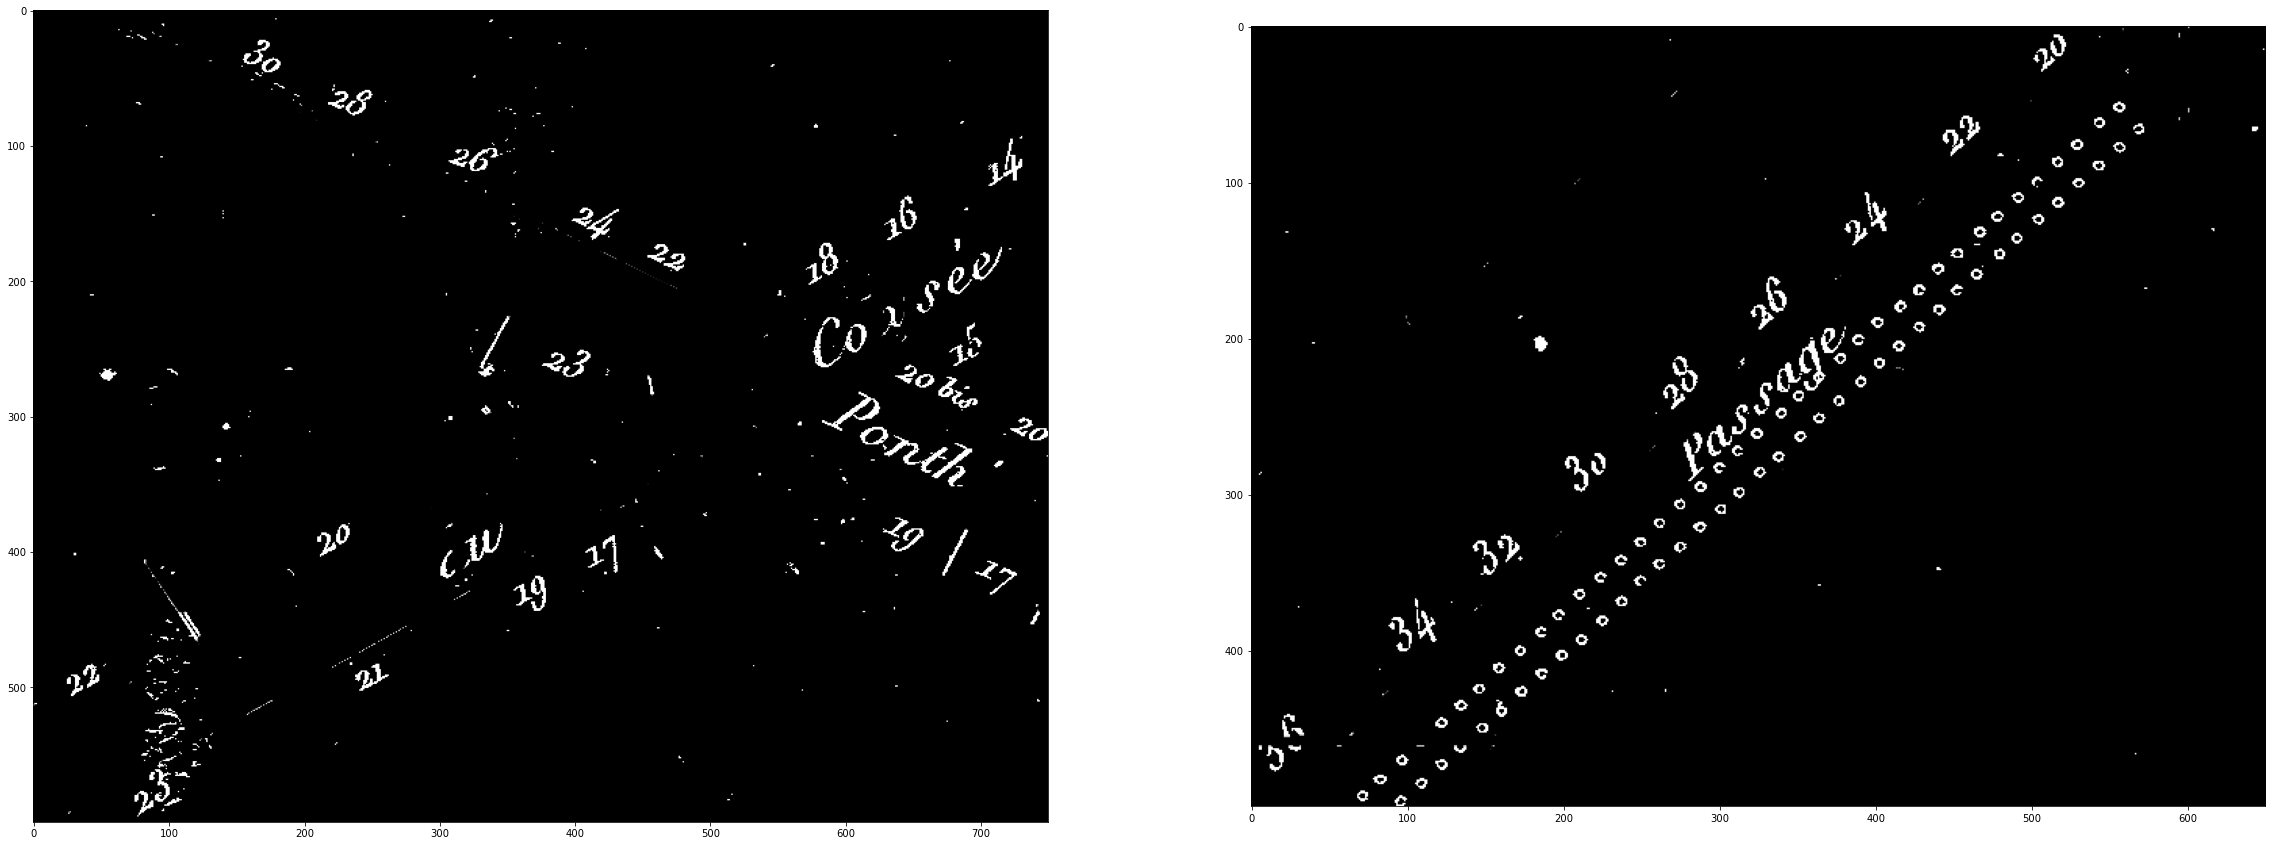

In [6]:
%%time
import sys
def removeSmallLines(image):
    n = 4
    for i in range (n):
        sys.stdout.flush()
        print( "removeSmallLines: ",int(i * 100/n), end='\r')
        lines = cv2.HoughLinesP(binary_img, rho=1, theta=np.pi/360, threshold=1, minLineLength=25, maxLineGap=1)
        removeLines(binary_img, lines, thickness=5)
    sys.stdout.flush()
    print( "removeSmallLines: DONE")

removeSmallLines(binary_img)


plt.figure(figsize=(30, 20))
plt.imshow(binary_img[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(binary_img[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(binary_img[4300:4800, 1100:1750], cmap='gray')

With mathematical morphology operations, we dilate what remains so that parts of numbers will not be detected when we will remove small objects.

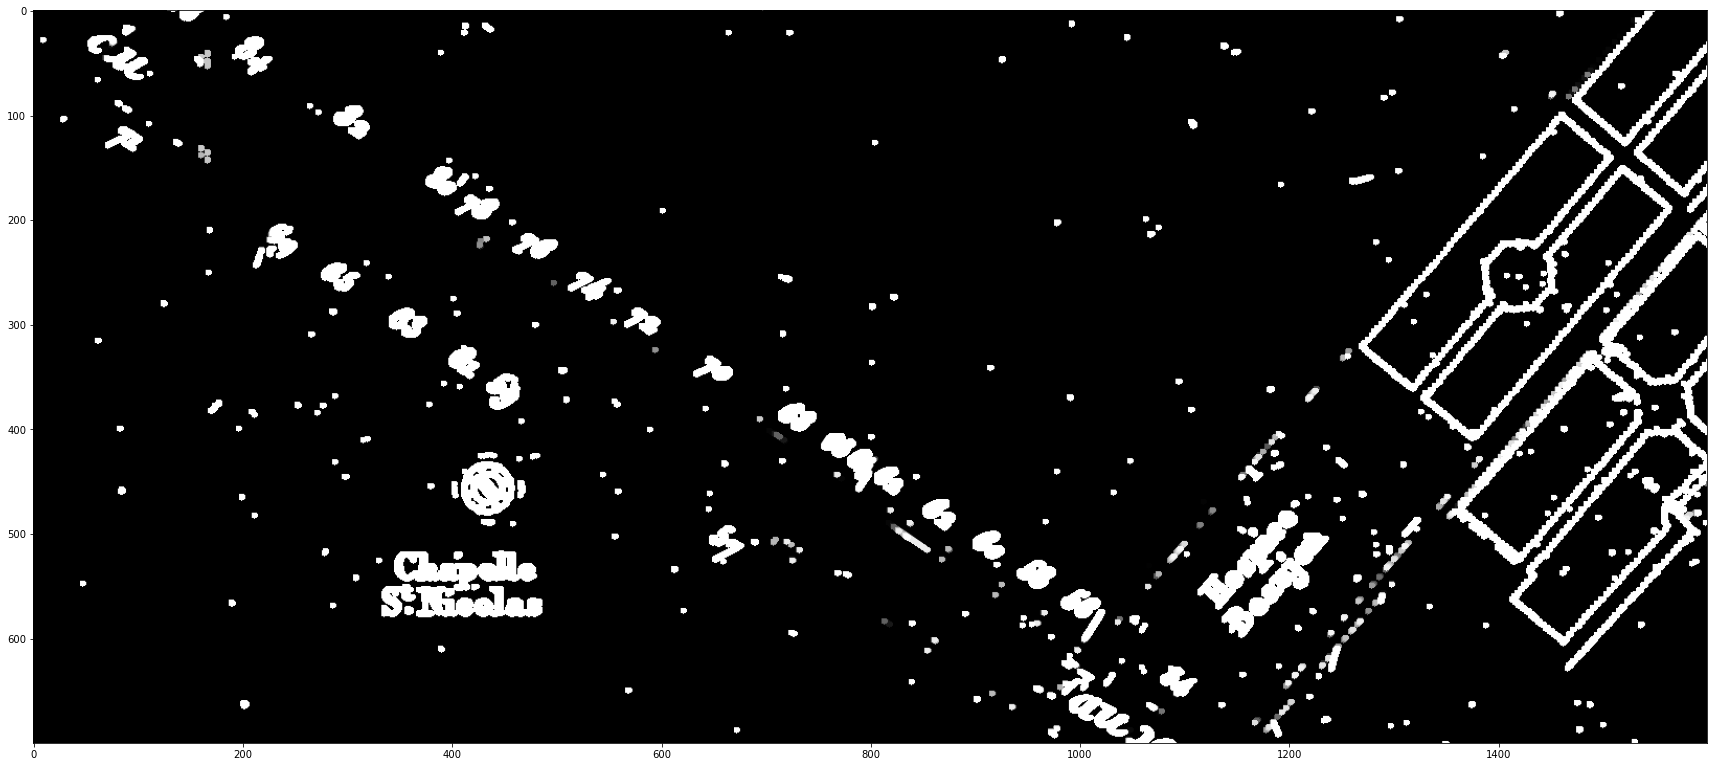

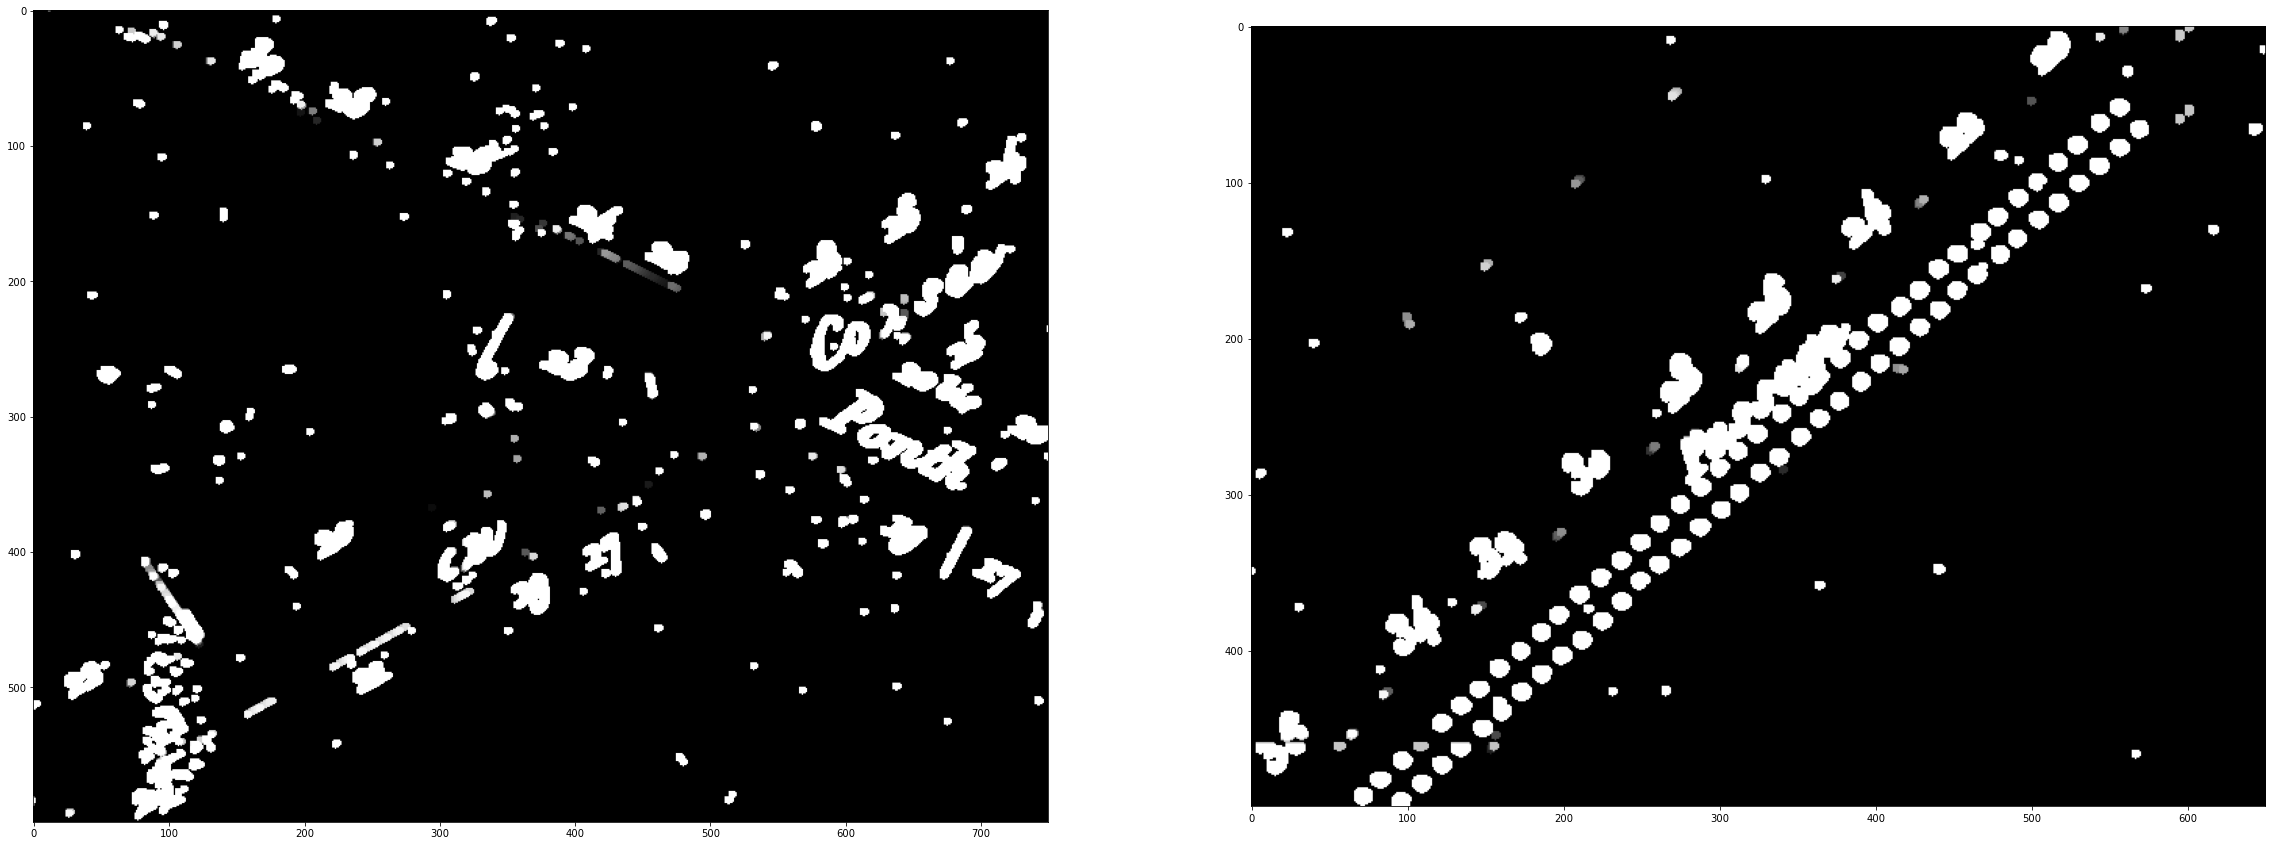

In [7]:
def applyMorphologyOP(image):
#     image = cv2.erode(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2)))
    return cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6)), iterations=1)

applied_morphology_image = applyMorphologyOP(binary_img)

plt.figure(figsize=(30, 20))
plt.imshow(applied_morphology_image[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(applied_morphology_image[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(applied_morphology_image[4300:4800, 1100:1750], cmap='gray')

removeSmallObjects: DONE


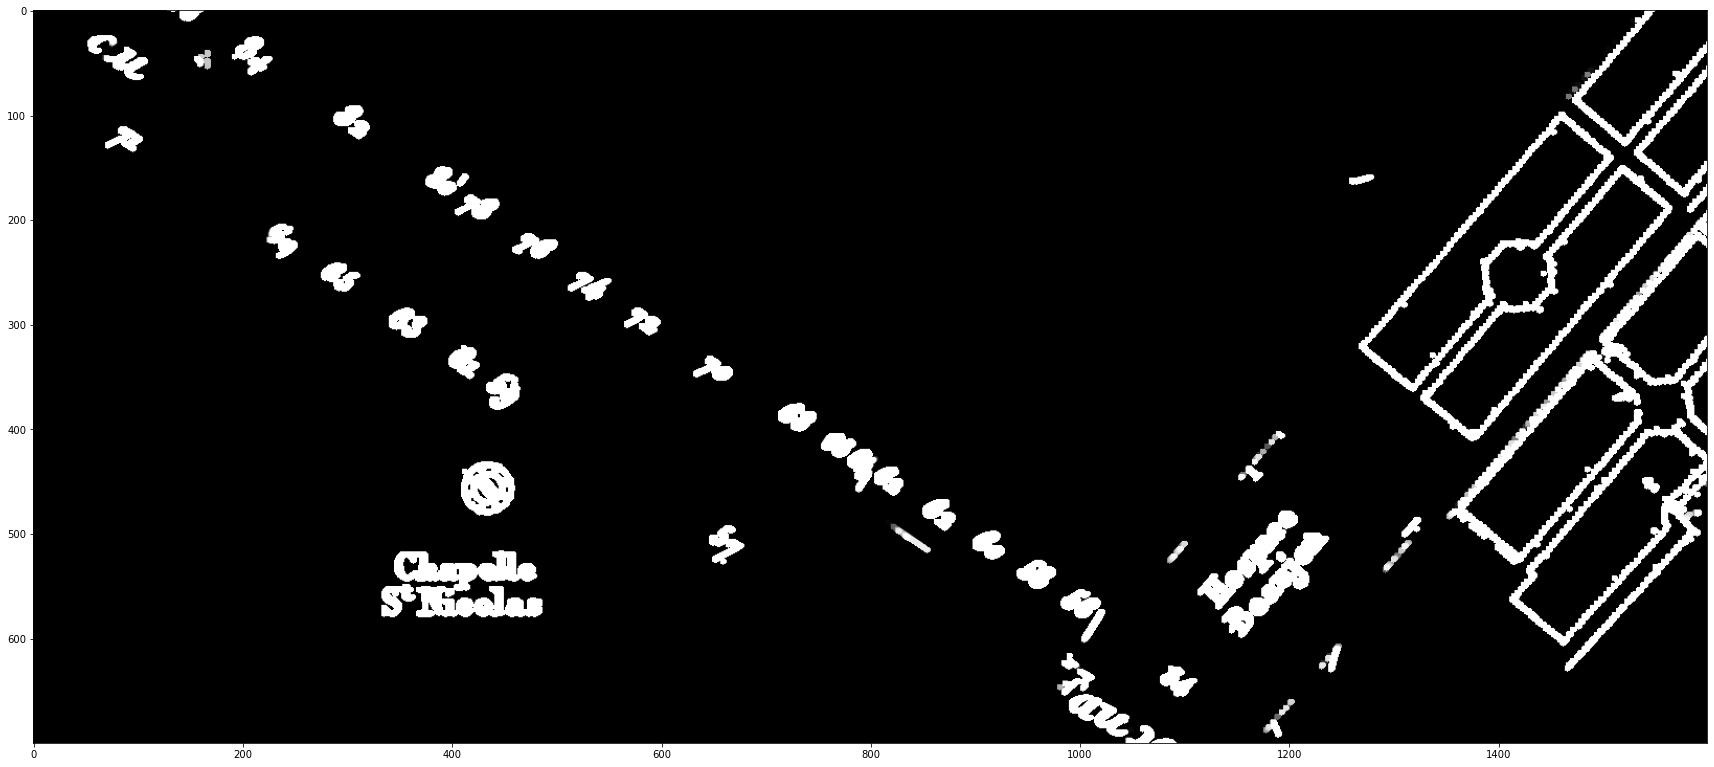

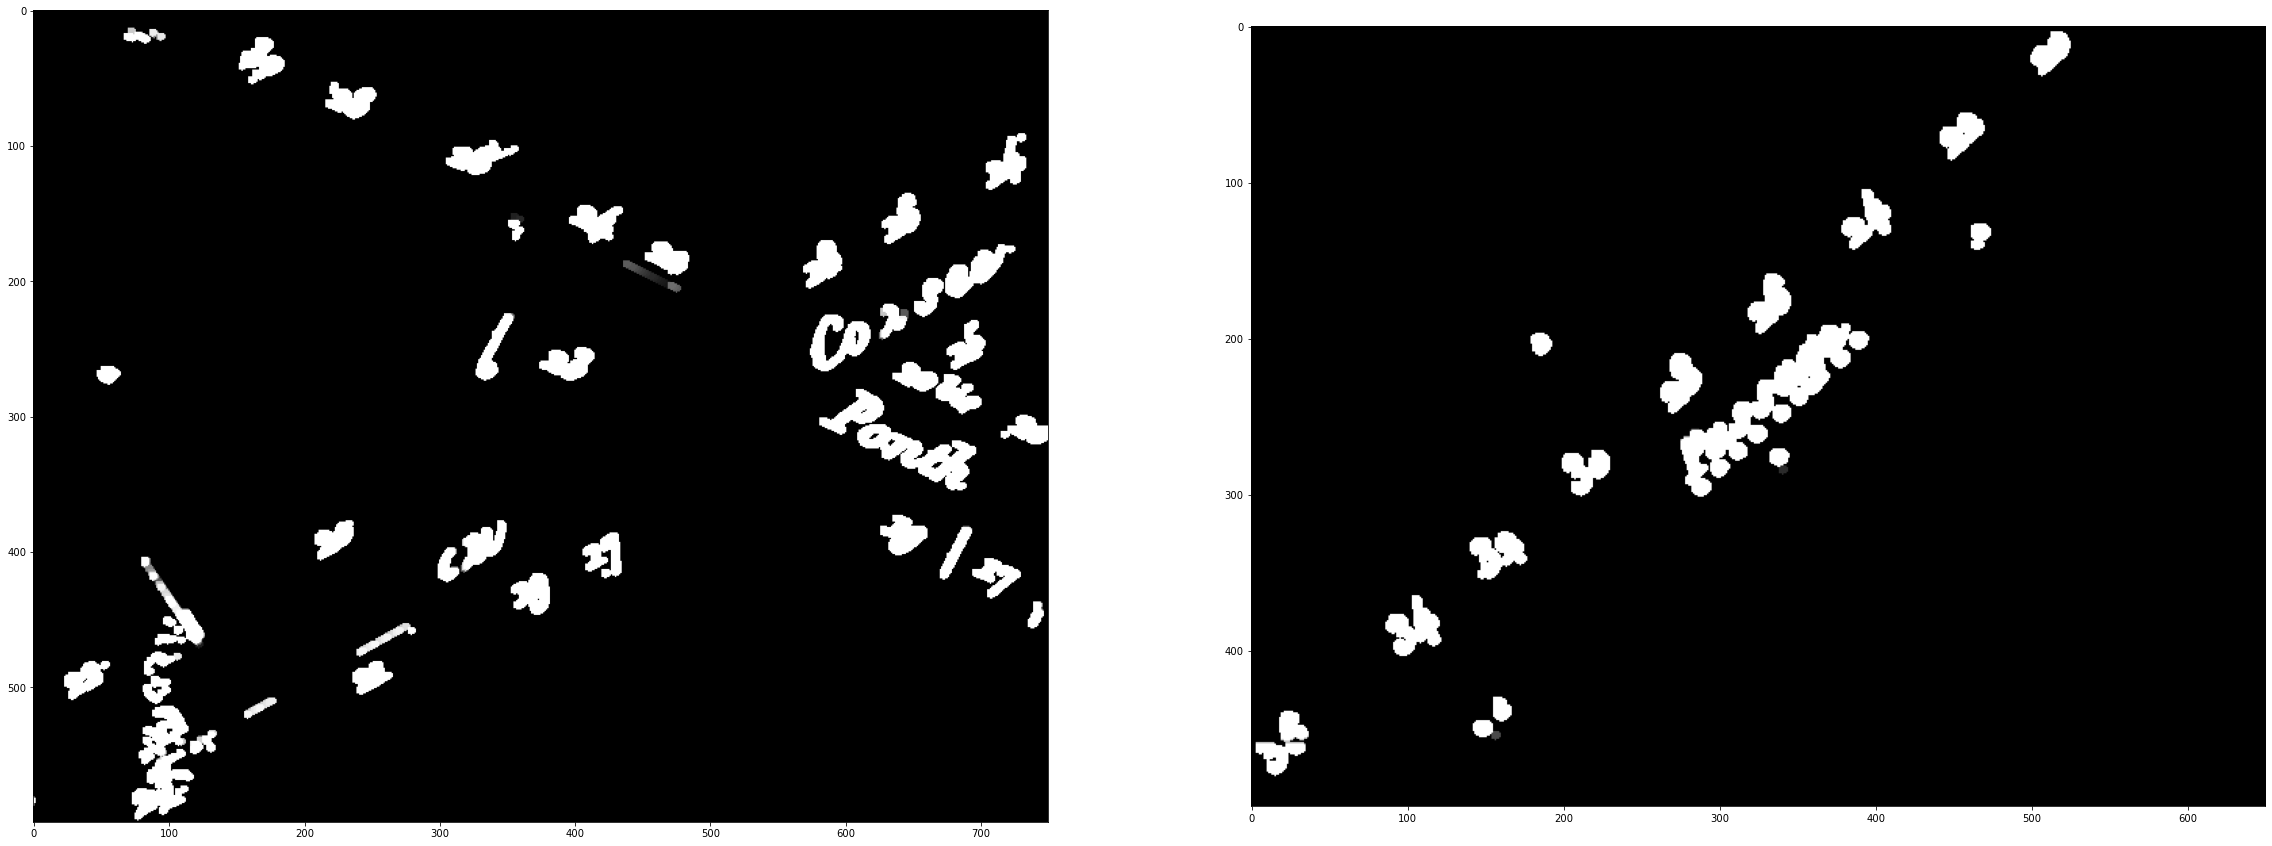

In [8]:
from skimage.morphology import remove_small_objects

def removeSmallObjects(image):    
    removed_image = remove_small_objects(image > 0, 150, in_place=True)
    image[~removed_image] = 0
    print("removeSmallObjects: DONE")
    
    
removeSmallObjects(applied_morphology_image)
plt.figure(figsize=(30, 20))
plt.imshow(applied_morphology_image[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(applied_morphology_image[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(applied_morphology_image[4300:4800, 1100:1750], cmap='gray')

We apply Canny filter in order to get some contours.

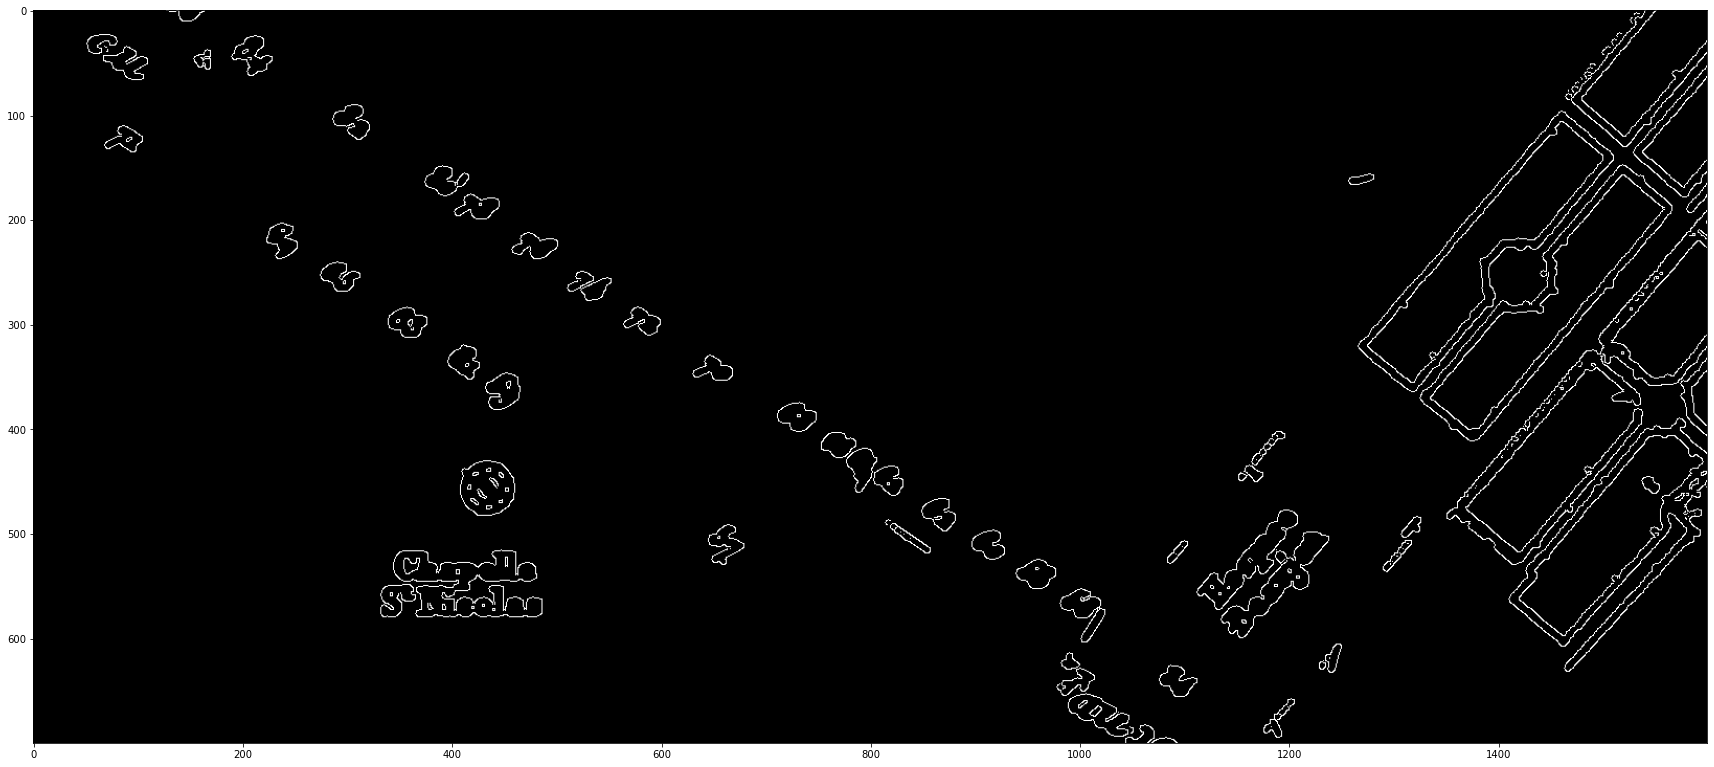

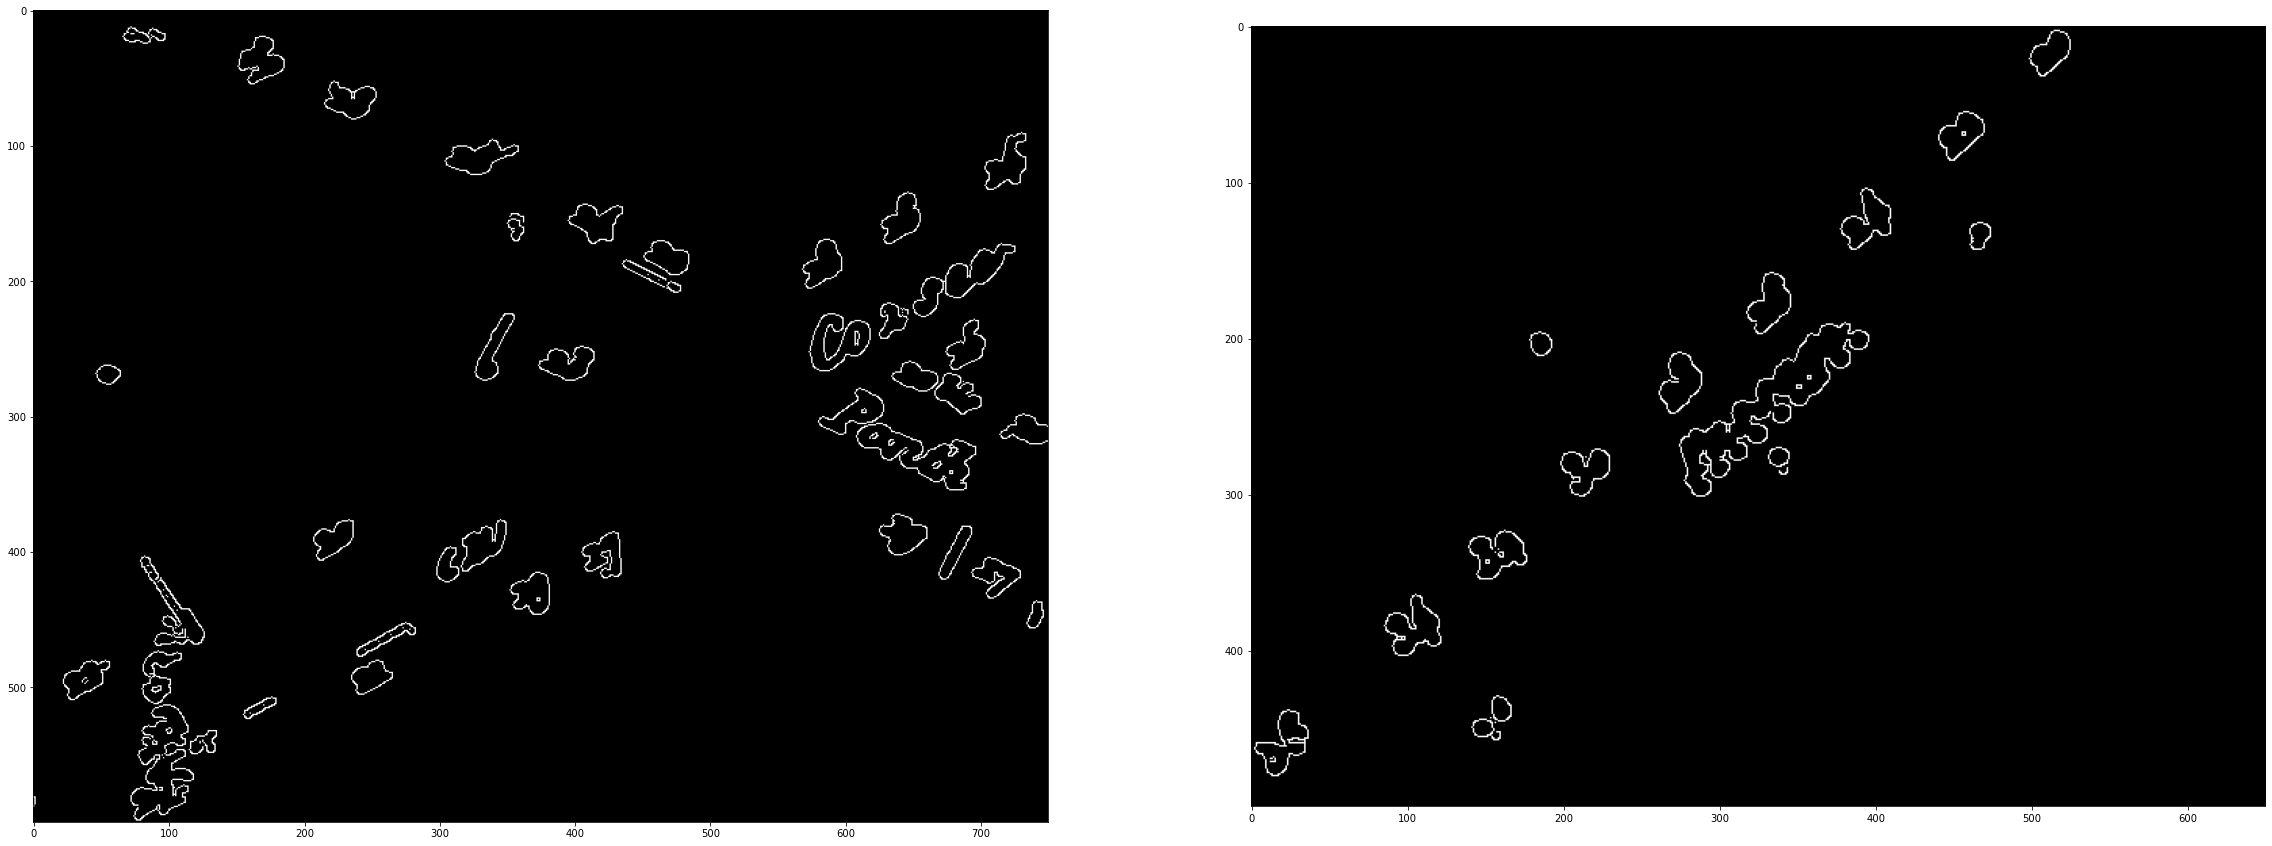

In [9]:
def getCannyImage(image):
    ret2,th2 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    high_thresh_val  = ret2
    lower_thresh_val = ret2 * 0.5
    return cv2.Canny(image, lower_thresh_val, high_thresh_val, apertureSize=5)

edged_image = getCannyImage(applied_morphology_image)

plt.figure(figsize=(30, 20))
plt.imshow(edged_image[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(edged_image[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(edged_image[4300:4800, 1100:1750], cmap='gray')

# Number detection

Now that our image has been preprocessed, we can detect where the numbers (or objects that look like numbers) are. Around all potential numbers, we draw their bounding box. When numbers are really numbers (composed of two digits or more), we merge bounding boxes of the digits that make up the number. We suppose that two relatively close bounding boxes are actually from the same number.

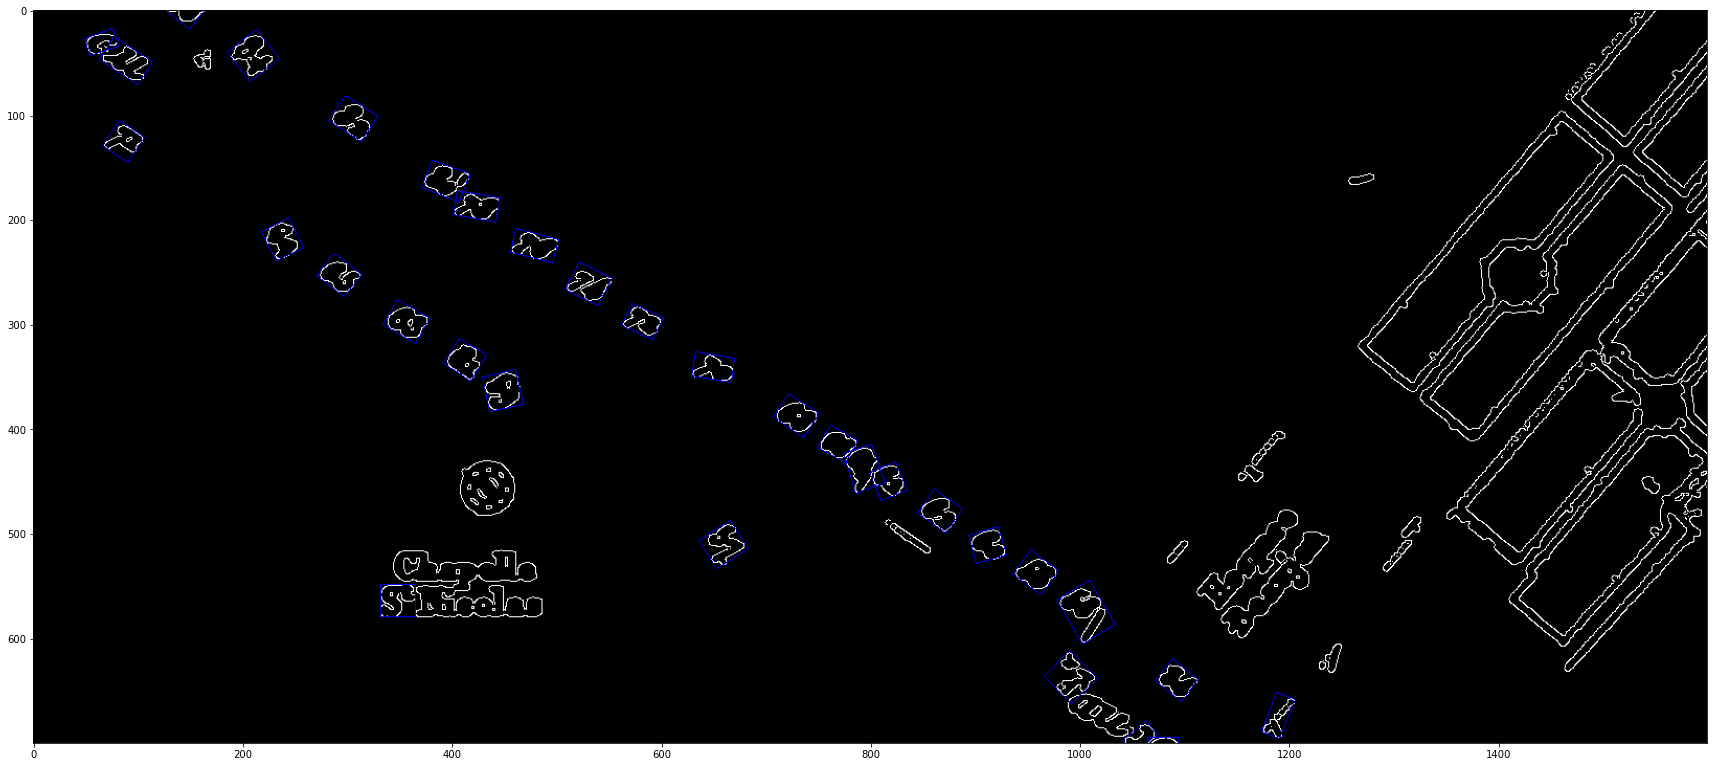

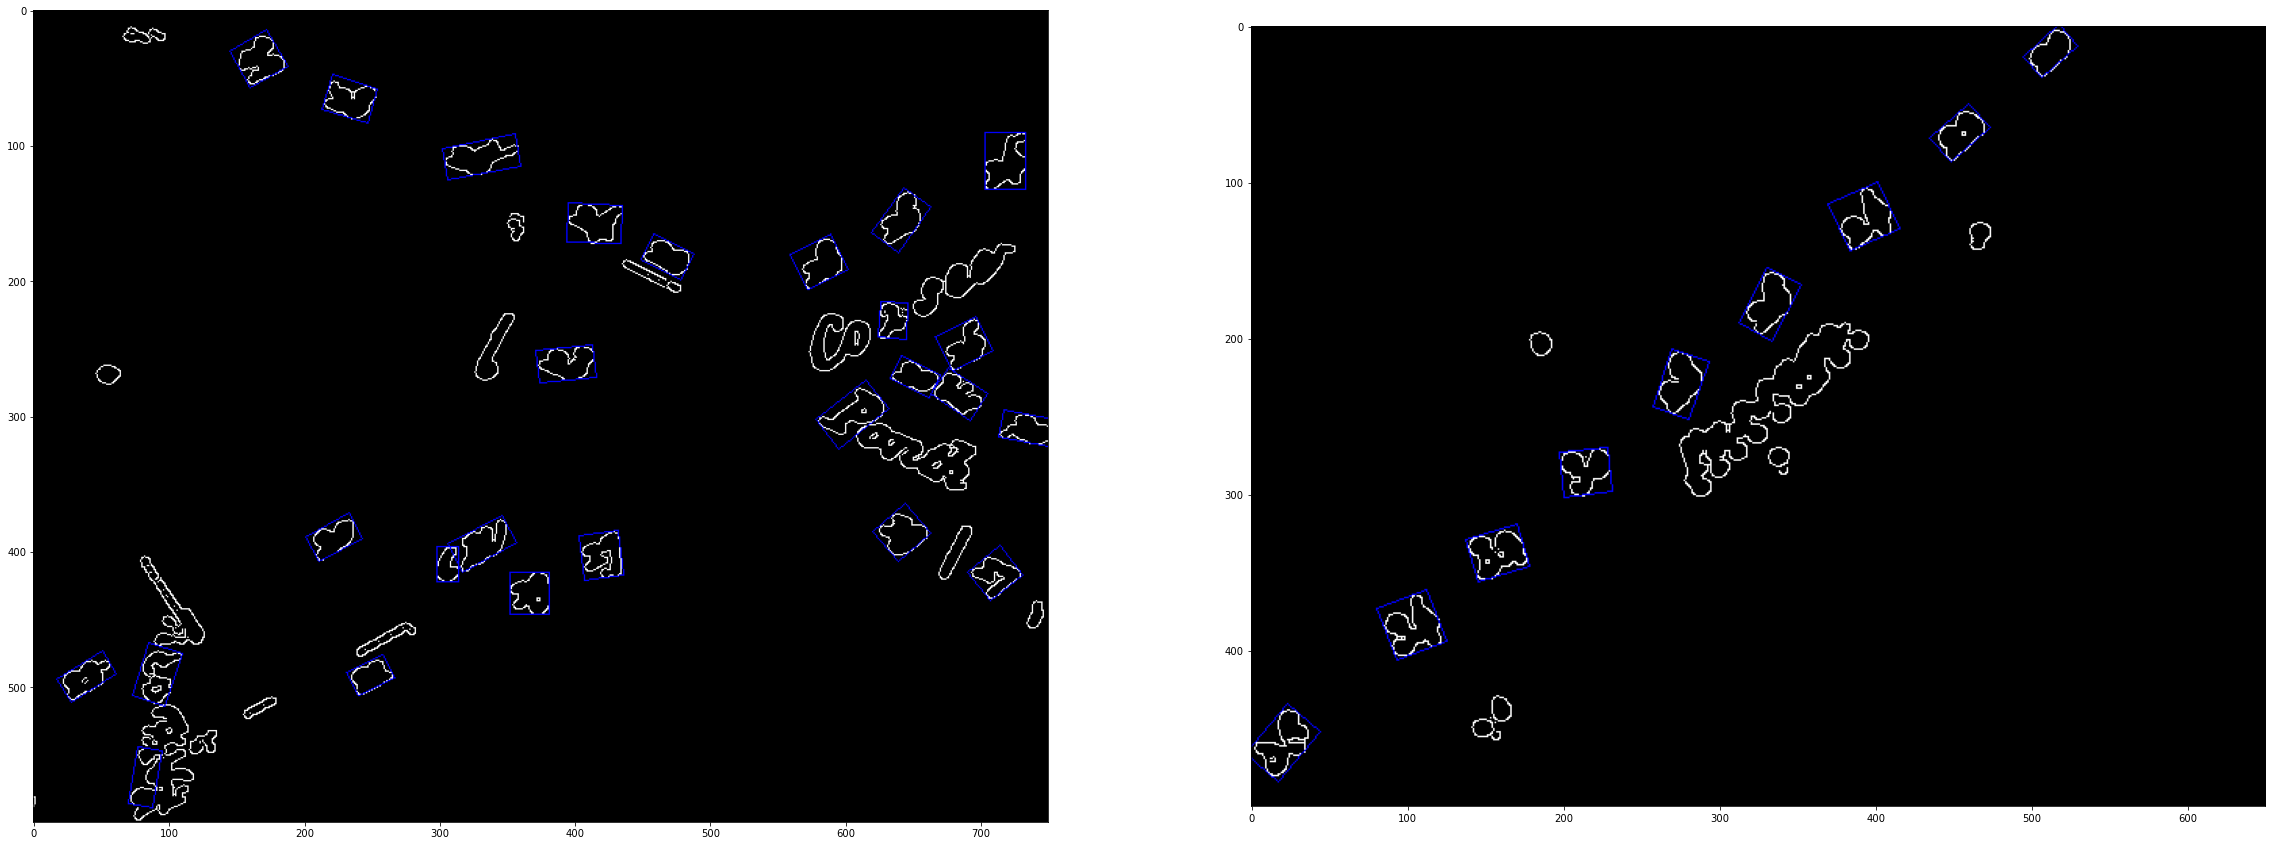

In [10]:
from math import hypot, sqrt

def getWidthHeight(box):
    l1 = hypot(box[1][0] - box[0][0], box[1][1] - box[0][1])
    l2 = hypot(box[2][0] - box[1][0], box[2][1] - box[1][1])
    if l1 < l2:
        return l1, l2
    else:
        return l2, l1
    
    
def distance(a, b):
    return sqrt((a[0] - b[0]) * (a[0] - b[0]) + (a[1] - b[1]) * (a[1] - b[1]))
    
def isNumberOrDigit(smallest, largest):
    return smallest > 15 and smallest < 40 and largest > 25 and largest < 60 and largest / smallest < 3.0
    
    
MAX_DISTANCE_BWT_DIGITS = 20


def getNumberBoundingBoxes(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    number_areas = []
    number_boxes = []
    
    for i, c in enumerate(contours):
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        smallest, largest = getWidthHeight(box)

        if isNumberOrDigit(smallest, largest):
            for i, rect2 in enumerate(number_areas):
                #merge boxes
                d = distance(rect[0], rect2[0])
                if d < MAX_DISTANCE_BWT_DIGITS:
                    rect = cv2.minAreaRect(np.append(cv2.boxPoints(rect2), box, axis=0))
                    box = cv2.boxPoints(rect)
                    number_areas.pop(i)
                    number_boxes.pop(i)
                    break

            number_areas.append(rect)            
            number_boxes.append(np.int0(box))

    return number_areas, number_boxes

def boundingBoxesImage(image, boxes):
    img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    img[:,:,0] = image.copy()
    img[:,:,1] = image.copy()
    img[:,:,2] = image.copy()
    cv2.drawContours(img, boxes, -1, (0, 0, 255), 0)
    return img


list_of_number_areas, boxes = getNumberBoundingBoxes(edged_image)


bounding_boxes_image = boundingBoxesImage(edged_image, boxes)

plt.figure(figsize=(30, 20))
plt.imshow(bounding_boxes_image[3600:4300, 3000:4600], cmap='gray')
plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.imshow(bounding_boxes_image[6800:7400, 5300:6050], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(bounding_boxes_image[4300:4800, 1100:1750], cmap='gray')

We define some functions that will crop the numbers in the previously created bounding boxes and add some padding to fit along the training dataset. We also divide the image in tiles of 100px * 100px to respect the competition's rules.

In [11]:
from scipy.ndimage import rotate
TILE_SIZE = 100
HALF_TILE_SIZE = int(TILE_SIZE/2)

def getImageCropped(image, rect, isNumber):
     # Get center, size, and angle from rect
    center, (width, height), theta = rect
    
    top = max(round(center[1]-HALF_TILE_SIZE), 0)
    bottom = round(center[1] + HALF_TILE_SIZE)
    left = max(round(center[0]-HALF_TILE_SIZE), 0)
    right = round(center[0] + HALF_TILE_SIZE)
    
    
    image = image[top:bottom, left:right]
    center = (center[0] - left, center[1] - top)
    if isNumber:
        size = int(width), int(height)
    else:
        size = int(width) + 2, int(height) + 2
        
    shape = (image.shape[1], image.shape[0]) # cv2.warpAffine expects shape in (length, height)
    
    matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=1)

    image = cv2.warpAffine(src=image, M=matrix, dsize=shape)
    image = cv2.getRectSubPix(image, size, center)
    if image is None:
        return None,  (left, top)
    if size[1] / size[0] > 1.2 and isNumber:
        image = rotate(image, angle=90)
    elif size[0] > size[1] and not isNumber:
        image = np.rot90(image)
        
    return image, (left, top)


TRAINED_IMG_W = 28
TRAINED_IMG_H = 28
BLACK = [0., 0., 0.]
from math import floor

def resize_image_with_padding(image):
    # the goal of this func to preserve aspect ratio 
    # and avoid distortion
    
    h, w = image.shape
    
    if h > TRAINED_IMG_H:
        w = floor(TRAINED_IMG_H * w / h)
        h = TRAINED_IMG_H
        image = cv2.resize(image, (w, h))

    if w > TRAINED_IMG_W:
        h = floor(TRAINED_IMG_W * h / w)
        w = TRAINED_IMG_W
        image = cv2.resize(image, (w, h))

    dt = floor((TRAINED_IMG_H - h)/2)
    db = ceil((TRAINED_IMG_H - h)/2)

    dl = floor((TRAINED_IMG_W - w)/2)
    dr = ceil((TRAINED_IMG_W - w)/2)
    
    #padding
    return cv2.copyMakeBorder(image, dt, db, dl, dr, cv2.BORDER_CONSTANT, value=BLACK)


def initDict(tile_dict, image, file_name=''):
    h_indices = list(range(0, image.shape[0], TILE_SIZE))
    w_indices = list(range(0, image.shape[1], TILE_SIZE))
    tile_ids = list(map(lambda res: file_name + "_" + str(res[0])+"_"+str(res[1]), product(w_indices, h_indices)))
    tile_dict.update(zip(tile_ids, ('' for _ in tile_ids))) 

# Number classification

Now that we know where the numbers are, we must decide if they're actually numbers, and if so, which ones. For each bounding boxes, we will first use the **isDigit** model trained in the *isDigit notebook* to decide if we consider it as a number. In that case, we then use the second model to predict the number.

In [12]:
from math import ceil
from itertools import product
from tensorflow.keras.models import load_model
from collections import defaultdict

#model link: https://www.kaggle.com/paduong/ign-model
PATH_TO_MODEL = '/kaggle/input/ign-model/'

model = load_model(PATH_TO_MODEL + 'model.hdf5')
isdigit_model = load_model(PATH_TO_MODEL + 'isdigit_model.hdf5')

MAX_DISTANCE_BWT_TINY_PARTS = 25
CONFIDENCE_THRESHOLD = 0.6
CONFIDENCE_ERROR_THRESHOLD = 0.6


def preprocessing_data(image_list):
    # return shape (number of image, 28, 28, 1)
    return np.expand_dims(np.array(image_list), 3) / 255.


def dilate(image, kernel=(5,5)):
    return cv2.dilate(image,  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel))


def merge_with_neighbour(contours, digit_areas, digit_boxes):
    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)

        if cv2.contourArea(cv2.boxPoints(rect)) < 100: #only connect tiny parts with bigger parts
            area_id = None
            min_d = float("inf")

            for i, rect2 in enumerate(digit_areas):
                d = distance(rect[0], rect2[0])
                if d < MAX_DISTANCE_BWT_TINY_PARTS and d < min_d:
                    min_d = d
                    area_id = i

            if area_id is not None:
                new_rect = cv2.minAreaRect(np.append(cv2.boxPoints(digit_areas[area_id]), box, axis=0))
                if cv2.contourArea(cv2.boxPoints(new_rect)) < 300:
                    rect = new_rect
                    box = cv2.boxPoints(rect)
                    box = np.intp(box)

                    digit_areas.pop(area_id)
                    digit_boxes.pop(area_id)

        box = np.intp(box)
        digit_areas.append(rect)
        digit_boxes.append(box) 

        
        
def choosing_confidences(digit_images, rot180_digit_images):
    confidences = model.predict(preprocessing_data(digit_images))
    if np.min(confidences.max(axis=1)) >= CONFIDENCE_THRESHOLD:
        return confidences
    
    rot180_confidences = model.predict(preprocessing_data(rot180_digit_images))

    if np.average(confidences.max(axis=1)) >= np.average(rot180_confidences.max(axis=1)):
        return confidences
    
    return rot180_confidences



def getNumberDict(tile_dict, binary_image, number_areas, image_name=''):
    numbers = []
    drawing_d =  defaultdict(lambda : [])
    confidence_d =  defaultdict(lambda : [])

    for i, area in enumerate(number_areas):
        print( "getDigits: ",int(i*100 / len(number_areas)), end='\r', flush=False)
        img, top = getImageCropped(binary_image, area, True)
        img = cv2.copyMakeBorder(img, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)
        binary_digit_img = img.copy()
    
        img = getCannyImage(img)
        contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
        
        # if the area is large => morph open to split the digits that stick together
        largest_c = max(contours, key=cv2.contourArea) 
        if (cv2.contourArea(largest_c) > 220):
            img = binary_digit_img.copy()
            img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2,2)))
            img = getCannyImage(img)
            contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

        
        contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)            
        digit_boxes = []
        digit_areas = []
        
        #merge tiny part of a digit
        merge_with_neighbour(contours, digit_areas, digit_boxes)
            
        #crop digit images   
        digit_areas = sorted(digit_areas, key=lambda r: r[0][0] * r[0][0] + r[0][1] * r[0][1])
        digit_images = []
        rot180_digit_images = []
        
        for rect in digit_areas:
            if cv2.contourArea(cv2.boxPoints(rect)) < 100:
                continue
            
            digit_img, _ = getImageCropped(binary_digit_img, rect, False)
            if digit_img is None or digit_img.size == 0:
                continue
            
            digit_img = resize_image_with_padding(digit_img)
            digit_images.append(digit_img)
            rot180_digit_images.append(rotate(digit_img, angle=180))

            
        x = int(floor(area[0][0]/TILE_SIZE)) * TILE_SIZE
        y = int(floor(area[0][1]/TILE_SIZE)) * TILE_SIZE
        drawing_d[image_name + "_" + str(x)+"_"+str(y)]+= digit_images
        
        #apply model on each digit image
        if len(digit_images) > 0:
            confidences = isdigit_model.predict(preprocessing_data(digit_images))
            if np.average(confidences.argmax(axis=1)) >= 0.5 and np.average(confidences.max(axis=1)) >= CONFIDENCE_ERROR_THRESHOLD:
                confidences = choosing_confidences(digit_images, rot180_digit_images)
                res = confidences.argmax(axis=1)

                number = ''.join(str(digit) for i, digit in enumerate(res) if confidences[i][digit] >= CONFIDENCE_ERROR_THRESHOLD)        
                if number:
                    tile_dict[image_name + "_" + str(x)+"_"+str(y)]+= number + ' '
        
            drawing_d[image_name + "_" + str(x)+"_"+str(y)].append(boundingBoxesImage(img, digit_boxes))
            confidence_d[image_name + "_" + str(x)+"_"+str(y)].append(confidences.max(axis=1))
            
            
    sys.stdout.flush()
    print( "getNumberDict: DONE")
    
    return drawing_d, confidence_d

tile_dict = {}
initDict(tile_dict, binary_img, '')
drawings, confidences = getNumberDict(tile_dict, binary_img, list_of_number_areas)

getNumberDict: DONE


All numbers from the image have been detected and classified. The following function displays some of them for monitoring. Most numbers are rightly classified. However, some had the wrong rotation, so the model made a mistake (9 instead of an upside down 5, ...).

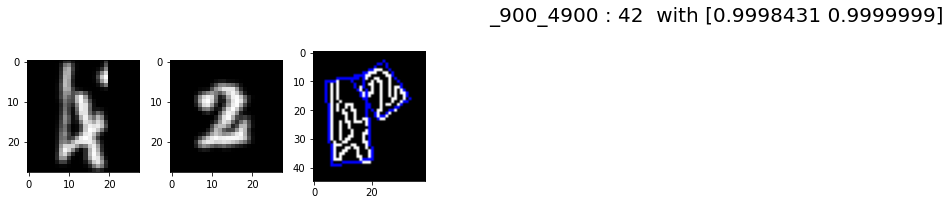

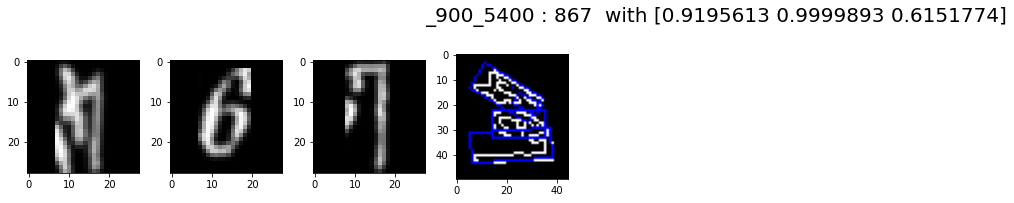

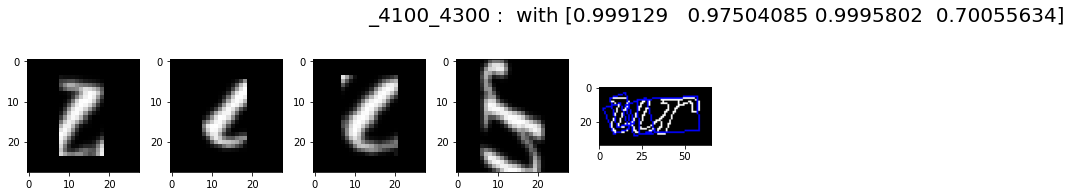

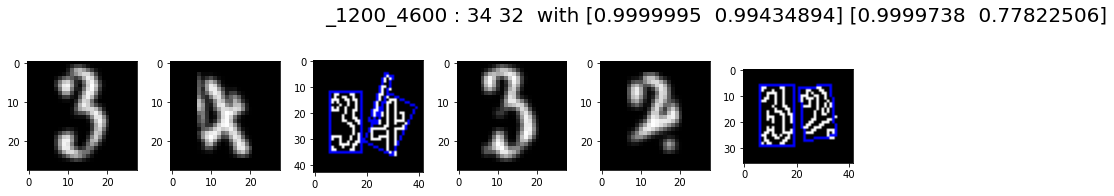

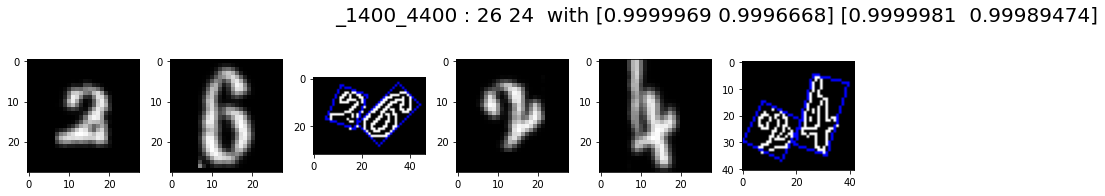

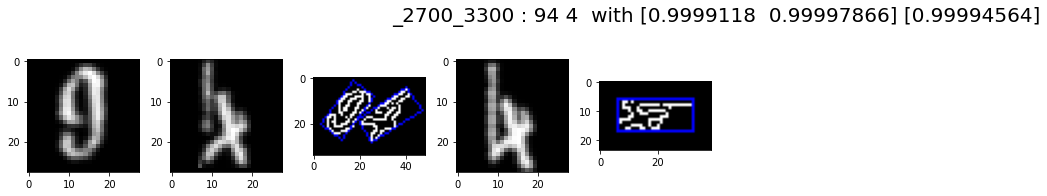

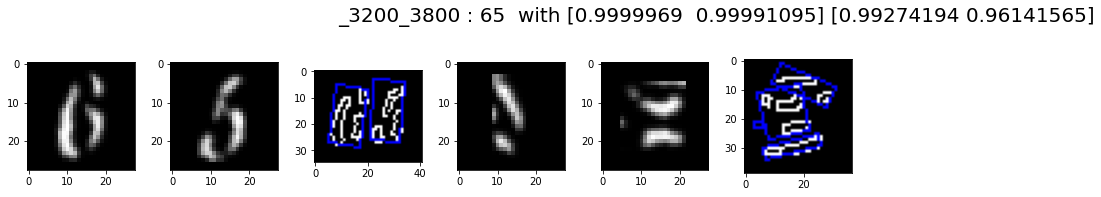

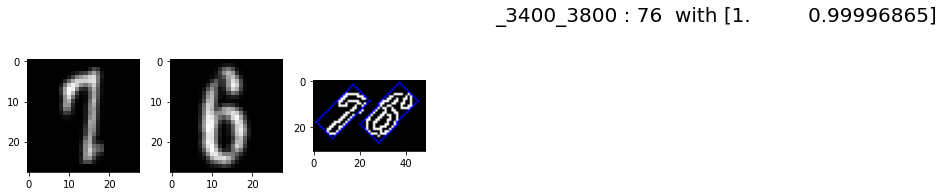

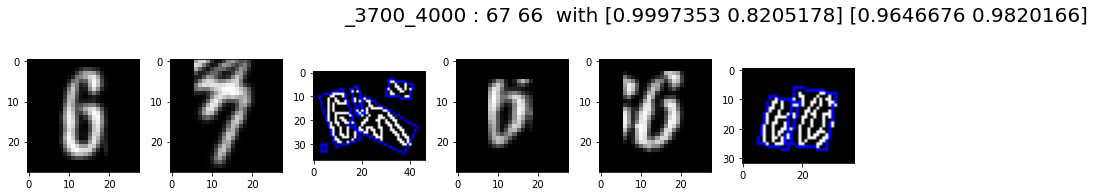

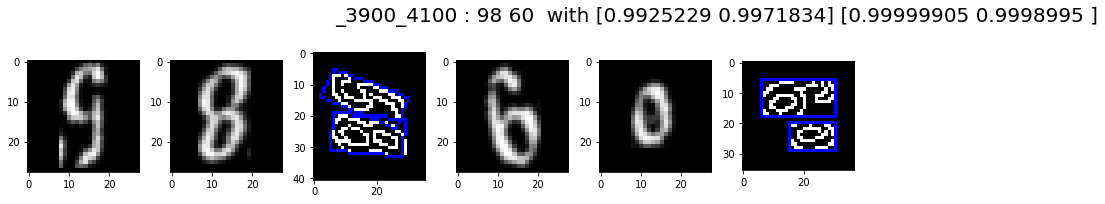

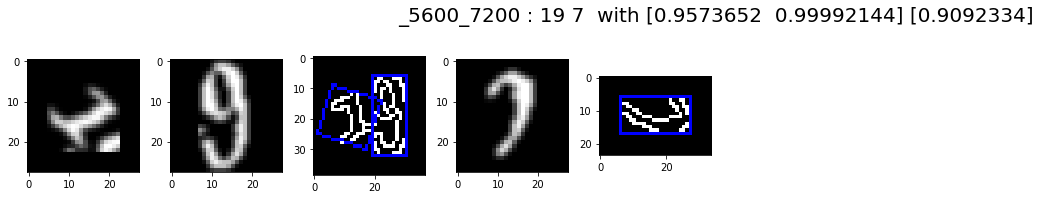

In [13]:
def show_images(images, n_rows=3, n_cols=5, figsize=(20, 20), title=None):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, size=20)

    for i, img in enumerate(images):
        if i >= n_rows * n_cols:
            break
        plt.subplot(n_rows, n_cols, 1 + i % (n_cols * n_rows))
        plt.imshow(img, cmap='gray')
    
    plt.tight_layout()
    
    
    
tile_ids = ["_900_4900", "_900_5400", "_4100_4300", "_1200_4600", "_1400_4400", "_2700_3300",  "_3200_3800", "_3400_3800", "_3700_4000", "_3900_4100",
           "_5600_7200"]

for tid in tile_ids:
    title = tid + ' : ' + tile_dict[tid] 
    title += ' with ' +  ' '.join(str(c) for c in confidences[tid])
    show_images(drawings[tid], figsize=(20, 10), n_cols=10, title=title)

# Application

We went through the whole process, for one image. The following apply those steps to each images of the dataset and output the csv file required for competition submission.

In [14]:
%%time
import pandas as pd
import os
table = {}

for path, img in zip(IMG_PATHS, images):
    filename = os.path.basename(path)[:-4]
    if filename =='Atlas_de_Jacoubet_-_07._Barrire_de_la_Villette_et_ses_environs_-_BHVP':
        filename = 'Atlas_de_Jacoubet_-_07._Barrière_de_la_Villette_et_ses_environs_-_BHVP'
    print(filename)
    
    binary_img = getBinary(img)
    removeBigLines(binary_img)
    removeLargeObjects(binary_img)
    removeSmallLines(binary_img)

    img = applyMorphologyOP(binary_img)
    removeSmallObjects(img)
    img = getCannyImage(img)
    number_areas, _ = getNumberBoundingBoxes(img)
    
    initDict(table, binary_img, filename)
    getNumberDict(table, binary_img, number_areas, filename)
    
        

df = pd.DataFrame(table.items(), columns=['ID', 'numero'])
df.to_csv("output_file.csv", index=False, index_label=False)

Atlas_de_Jacoubet_-_04._Partie_de_la_commune_de_Clichy_et_de_ses_environs_-_BHVP
removeBigLines: Done
removeLargeObjects: DONE
removeSmallLines: DONE
removeSmallObjects: DONE
getNumberDict: DONE
Atlas_de_Jacoubet_-_05._Partie_de_la_commune_de_Montmartre_et_de_ses_environs_-_BHVP
removeBigLines: Done
removeLargeObjects: DONE
removeSmallLines: DONE
removeSmallObjects: DONE
getNumberDict: DONE
Atlas_de_Jacoubet_-_06._Partie_de_la_commune_de_La_Chapelle_et_de_ses_environs_-_BHVP
removeBigLines: Done
removeLargeObjects: DONE
removeSmallLines: DONE
removeSmallObjects: DONE
getNumberDict: DONE
Atlas_de_Jacoubet_-_07._Barrière_de_la_Villette_et_ses_environs_-_BHVP
removeBigLines: Done
removeLargeObjects: DONE
removeSmallLines: DONE
removeSmallObjects: DONE
getNumberDict: DONE
Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses_environs_-_BHVP
removeBigLines: Done
removeLargeObjects: DONE
removeSmallLines: DONE
removeSmallObjects: DONE
getNumberDict: DONE
CPU times: user 6min 36s, sys: 9.41 s, total

In [15]:
df.count

<bound method DataFrame.count of                                                       ID numero
0      Atlas_de_Jacoubet_-_04._Partie_de_la_commune_d...       
1      Atlas_de_Jacoubet_-_04._Partie_de_la_commune_d...       
2      Atlas_de_Jacoubet_-_04._Partie_de_la_commune_d...       
3      Atlas_de_Jacoubet_-_04._Partie_de_la_commune_d...       
4      Atlas_de_Jacoubet_-_04._Partie_de_la_commune_d...       
...                                                  ...    ...
22459  Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses...       
22460  Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses...       
22461  Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses...       
22462  Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses...       
22463  Atlas_de_Jacoubet_-_11._Hospice_Beaujon_et_ses...       

[22464 rows x 2 columns]>